# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Auditoria Automática de Vídeo Baseada em Modelos de Deep-Learning

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**. Se pretende executar localmente prefira a versão local deste notebook, sem o sufixo ```-collab```.

## 1. Introdução

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas. Por meio uma trilha guiada para construir uma aplicação que tem por objetivo analisar imagens e extrair uma série de informações que serão utilizadas para compor uma análise de imagens e vídeos afim de construir uma forma de auditoria automatizada baseado em modelos de inteligência artificial.


<p align="center">
<img src="https://github.com/michelpf/fiap-ml-visao-computacional-capstone/blob/master/projeto/imagens-aux/example.png?raw=1">
</p>


Este projeto poderá ser feito por grupos de até 4 pessoas.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Carlos Eduardo Barbosa   | RM 335518     | `10IA` |
| Daniel Gregoris Guarino  | RM 335398     | `10IA` |
| Fabio de Campos Bordin   | RM 336263     | `10IA` |
| Fernando Bareno Calo     | RM 335434     | `10IA` |

Por ser um projeto guiado, fique atento quando houver as marcações **Implementação** indica que é necessário realizar alguma implementação em Python no bloco a seguir onde há a inscrição ```## IMPLEMENTAR``` e **Resposta** indica que é esperado uma resposta objetiva relacionado a algum questionamento. 

**Cada grupo pode utilizar nas respostas objetivas quaisquer itens necessários que enriqueçam seu ponto vista, como gráficos, fotos e, até mesmo, trechos de código-fonte.**

Pode-se utilizar quantos blocos forem necessários para realizar determinadas implementações ou utilizá-las para justificar as respostas. Não é obrigatório utilizar somente o bloco indicado.

Ao final não se esqueça de subir os arquivos do projeto nas contas do GitHub de cada membro, ou subir na do representante do grupo e os membros realizarem o fork do projeto.

A avaliação terá mais ênfase nos seguintes tópicos de desenvolvimento do projeto:
 
1. __Modelo de identificação de idades__
2. __Modelo de identificação de gênero__
3. __Extração de faces (região de interesse)__
4. __Análise de vídeo e extração de objetos__
5. __Conclusões Finais__

Para cada item haverá uma métrica de sucesso a ser perseguida e recomendações de como atingi-la. De todo modo os grupos terão liberdade para propor abordagem _ligeiramente_ diferentes para atinger as mesmas métricas. Apenas fica vetado o uso de APIs baseadas em cloud.

### 1.1 Componentes obrigatórios

Todas as bibliotecas já estão instaladas no Google Colab.

* Keras
* Scikit-learn
* Seaborn
* DLib
* OpenCv
* Pandas
* Numpy

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

#Exibição na mesma tela do Jupyter
%matplotlib inline

from os import listdir
from os.path import isfile, join

import pandas as pd
import dlib

import ast 
from sklearn.model_selection import train_test_split

import os

from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Convolution2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow import keras
plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.1.1 Utilizando Google Drive

Se usar o Google Drive para armazenar as imagens utilize o comando abaixo para montar seu drive.
Você pode navegar pelas pastas pelo painel ao lado.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 1.1.2 Utilizando o armazenamento efêmero

Se optar pelo armazenamento efêmero você precisa enviar os arquivos de imagens (arrastar e soltar) para as pastas que deverão ser criadas na estrutura do Colab e nas pastas que serão criadas no clone do repositório.

### 1.1.3 Materiais de suporte e conjunto de dados

As imagens e vídeos que serão utilizados no projeto estão no repositório. 

In [ ]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional-capstone

Cloning into 'fiap-ml-visao-computacional-capstone'...
remote: Enumerating objects: 52756, done.
remote: Total 52756 (delta 0), reused 0 (delta 0), pack-reused 52756
Receiving objects: 100% (52756/52756), 695.88 MiB | 52.01 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Checking out files: 100% (62350/62350), done.


Neste projeto fizemos o clone do repositório para acessar as imagens necessárias para o treinamento das CNN (reconhecimento da idade e sexo dos rostos identificados na imagem), os comandos para normalizar e redimensionar as imagens são muito mais performáticos quando estas estão armazenadas diretamente no Google Colab do que no Google Drive. Por outro lado utilizamos o Google Drive para armazenar e acessar os modelos e pesos default das redes e para salvar os modelos e pesos das redes treinadas por nós (arquivos *.h5), para este caso fazer o upload destes arquivos no Colab leva muito tempo e isso deve ser feito toda vez que o ambiente de trabalho é reiniciado. Em função disso em vários momentos do projeto são usados comandos de terminal para mudar do diretório do Colab para o Google Drive e vice versa conforme a necessidade.

## 1.2 O problema

Atualmente, com a tecnologia disponível e acessível, sobretudo na obtenção de imagens e vídeos e em seu processamento, permite apoiar com mais ênfase atividades de auditoria e investigação de forma automatizada, sem a necessidade de uma pessoa realizar tais análises e ainda com maior acurácia.

O uso de tecnologias relacionadas a visão computacional pode contribuir para tornar mais eficiente investigações de pessoas e objetos baseadas em suas características e em seu perfil, além de tornar esta atividade mais rápida e completa.

A proposta deste projeto é apoiar uma aplicação de auditoria e investigação para automatizar a busca por regiões de interesse (objetos e determinadas pessoas) com as seguintes finalidades:

* Encontrar pessoas do gênero masculino com mais de 45 anos de idade
* Encontrar pessoas do gênero femimino com menos de 45 anos de idade
* Encontrar objetos relacionados a informática, como computadores e telefones

Uma busca manual em vídeos de vigilância é bem onerosa e pode deixar passar evidências importantes em processos investigativos.

Ainda assim, a análise humana é realizada em último caso para decidir, se dentre as evidências coletadas, quais devem seguir para investigação mais apurada e quais não. A tarefa humana é mais de validação do que exploração.

Para alcançar este objetivo iremos construir uma aplicação capaz de analisar um vídeo específico de um escritório, baseado na série de TV [_The Office_](https://pt.wikipedia.org/wiki/The_Office). A partir dele e de modelos de classificação de imagens, iremos coletar e armazenar imagens das regiões de interesse citadas para posterior análise de investigações.

Deste modo, conforme já apresentado, seguiremos com o seguinte roteiro:

* Desenvolver e construir um classificador de idade
* Desenvolver e construir um classificador de gênero
* Eleger a melhor forma de segmentar uma imagem de face
* Configurar um modelo de detecção de objetos
* Analisar um vídeo e extrair as regiões de interesse

Por fim, deverá ser realizado uma conclusão deste estudo, apresentando como foi a realização deste processo, pontos de acerto, pontos de melhoria e como poderia ser feito para aperfeiçoar os resultados.

## 2. Construção de modelos em redes neurais profundas

Nesta primeira parte, iremos construir um modelo baseado em redes neurais profundas (_deep learning_) capaz de identificar, a partir de uma imagem, qual é a idade da pessoa.

Este tipo de classificador requer um mapeamento mais profundo de cada imagem além de ser necessário um número considerável de imagens para cada idade ou faixa de idade.

Devido a necessidade de um número alto de imagens, vamos utilizar o dataset [IMDB-WIKI – 500k+ face images with age and gender labels](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki) que foi utilizado no desafio _DEX: Deep EXpectation of apparent age from a single image_.

Também foram utilizados dois excelentes artigos de Sefik Ilkin Serengil, que podem ser acessados [aqui](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras) e [aqui](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras). Esses artigos demonstram a aplicação do VGGFace para as tarefas de reconhecimento de idade e gênero. Artigos que foram ligeiramente adaptados e utilizados para o desafio.

As imagens estão disponíveis na pasta ```imagens```.

O arquivo ```age-faces-dataset.csv```, na pasta ```csv``` possui a relação de cada sujeito, contendo sua idade, localização da face, idade e referência da imagem, gênero, dentre outros campos. Com esta referência é possível associar determinado sujeito com sua face.

No conjunto de dados, a representação do gênero masculino é codificada com o valor *1* e o gênero feminino com o valor *0*.

Abra o conjunto de dados utilizando o _Pandas_. Utilize o método ```read_csv```.

In [ ]:
%ls

drive/  fiap-ml-visao-computacional-capstone/  sample_data/


In [ ]:
%cd fiap-ml-visao-computacional-capstone/

/content/fiap-ml-visao-computacional-capstone


In [ ]:
# IMPLEMENTAR
df = pd.read_csv('projeto/csv/age-faces-dataset.csv')

Execute o comando abaixo para apresentação de uma amostra do conjunto de dados.

In [ ]:
df.head()

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth age
0           0  723671         2009  ...               NaN           1981  28
1           2  711677         2008  ...               NaN           1948  60
2           4  720044         2012  ...               NaN           1971  41
3           5  716189         2012  ...               NaN           1960  52
4           6  707745         1971  ...               NaN           1937  34

[5 rows x 11 columns]

In [ ]:
df.shape

(22155, 11)

In [ ]:
# feature second_face_score só possui valores nulos
df.isnull().sum()

Unnamed: 0               0
dob                      0
photo_taken              0
full_path                0
gender                   0
name                     0
face_location            0
face_score               0
second_face_score    22155
date_of_birth            0
age                      0
dtype: int64

### 2.1 Modelo de predição de idade

Antes de começarmos, avalie o conjunto de dados _Pandas_ e verifique se existe alguma otimização.
Sugerimos verificar e filtrar somente sujeitos com idade maior do que 0 e menor do que 100.

Analise o histograma e investigue com filtros do _Pandas_ para avaliar se existe necessidade de realização de algum _data cleasing_ no dataset, de acordo com a sugestão pedida.

Havendo necessidade de _data cleasing_ realize os devidos ajustes.

Vamos investigar a distribuição de idades pelo histograma.
Execute o comando abaixo.

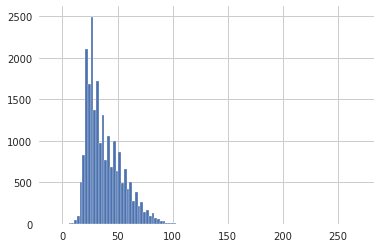

In [ ]:
histograma_idade = df['age'].hist(bins=df['age'].nunique())

De acordo com os dados de idade, vamos buscar a existência de idades que não serão foco dos modelos, por exemplo, idades inferiores a 25 e superiores a 60.

In [ ]:
df[df['age'] < 0]

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth age
16538       46820  715674         1952  ...               NaN           1959  -7

[1 rows x 11 columns]

Agora idades maiores do que 100.

In [ ]:
df[df['age'] > 100]

Unnamed: 0     dob  photo_taken  ... second_face_score  date_of_birth  age
305           917  677949         1960  ...               NaN           1856  104
1658         4533  679576         1963  ...               NaN           1860  103
3282         9040  696641         2008  ...               NaN           1907  101
7019        19680  636872         2012  ...               NaN           1743  269
7124        19951  693780         2013  ...               NaN           1899  114
7520        21139  694318         2011  ...               NaN           1900  111
7607        21361  696659         2011  ...               NaN           1907  104
7894        22151  642953         1945  ...               NaN           1760  185
11725       32956  688477         2004  ...               NaN           1884  120
13955       39420  693822         2009  ...               NaN           1899  110
16220       45990  692787         2007  ...               NaN           1896  111
18464       52282  689607         1990  ...               NaN           1888  102
21478       60480  694718         2004  ...               NaN           1902  102
21951       61818  658516         2012  ...               NaN           1802  210

[14 rows x 11 columns]

Diante dos dados apresentados, realize a limpeza dos registros com idades inválidas ou de não interesse do projeto.
Para realizar a limpeza utilize da seguinte forma:

```python
df = df[df['age'] <= idade_limite_superior]
df = df[df['age'] > idade_limite_inferior]
```

Agora implemente a limpeza dos dados.

In [ ]:
# IMPLEMENTAR
idade_limite_superior = 100
idade_limite_inferior = 0

df = df[df['age'] <= idade_limite_superior]
df = df[df['age'] > idade_limite_inferior]

Vamos executar novamente os comandos abaixo para ter certeza que os dados foram limpos.

In [ ]:
len(df[df['age'] > 100]), len(df[df['age'] < 0])

(0, 0)

Se o resultado obtido foi 0 para ambos os filtros (exemplo (0,0)) signfica que estamos prontos para avançar.

In [ ]:
# no início o dataset possuia 22155 registros
# com a filtragem por idade mínima e máxima agora temos
# 22138 registros no dataset
df.shape

(22138, 11)

### 2.2 Transfer learning

A técnica de _transfer learning_ é particularmente útil ao combinar modelos já validados em aplicações mais robustas, resultado de competições de grande porte.

Um benchmark nesse campo aplicado a faces é o [VGGFace](http://www.robots.ox.ac.uk/~vgg/data/vgg_face) do grupo *VGG*, o Visual Geometry Group da Univerdade de Oxford.

A arquitetura proposta pelo VGGFace é capaz de classificar faces com precisão acima de 90% em alguns trabalhos, como por exemplo [Zhang, Lingfeng & Kakadiaris, Ioannis. (2017). Local classifier chains for deep face recognition. 158-167](https://www.researchgate.net/publication/322872468_Local_classifier_chains_for_deep_face_recognition).

Este modelo tem a seguinte arquitetura.

<p align="center">
<img src="https://github.com/michelpf/fiap-ml-visao-computacional-capstone/blob/master/projeto/imagens-aux/vgg-face-architecture.jpg?raw=1">
</p>

Observando a primeira camada, precisamos portanto padronizar as imagens de treinamento no tamanho 224 x 224 (comprimento x largura).

Os grupos que decidirem criar modelos alternativos devem explicar qual arquitetura utiliza e seus motivadores.

### 2.3 Padronização de imagens

O algoritmo abaixo normaliza as imagens para o tamanho de entrada do modelo VGGFace e também converte o valor em intenside de pixel de 0 a 255 para 0 a 1, com valores em pontos flutuantes.

Valores em ponto flutuante são melhores para se trabalhar com convergência de modelos durante os cálculos entre as camadas das redes neurais.

> Atenção: para melhor controlar a quantidade de memória, opte por incluir mais ou menos imagens por classe. Abaixo a variável ```qtde_imagens_classe``` regula isso. Ambientes limitados do Colab a recomendação é no máximo 200. Fique a vontade para inclui mais, pois quanto maior o número de imagens, mais preciso é o modelo. Cada classe possui cerca de 600 imagens.

In [ ]:
from tqdm import tqdm_notebook as tqdm

tamanho_imagem = (224, 224)
faces = []

for index, row in tqdm(df.iterrows()):
    image_face = image.load_img("projeto/imagens/%s" % ast.literal_eval(row["full_path"])[0], grayscale=False, target_size=tamanho_imagem)
    image_array = image.img_to_array(image_face).reshape(1, -1)[0]
    image_array /= 255
    faces.append(image_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Verifique a quantidade de imagens de faces obtidas pelo conjunto de dados.

In [ ]:
# IMPLEMENTAR
qtd_faces = len(faces)

In [ ]:
print("O total de faces de imagens é de " + str(qtd_faces) + ".")

O total de faces de imagens é de 22138.


### 2.4 Definição do modelo

O próximo passo é a definição do número de classes. Como a definição de classes é _zero based_ sempre defina adicionando 1 ao valor final.

Exemplo, se o número de classes compreender entre idades maior do que 0 e menor ou igual a 100, teremos 100 classes, logo o número de classes de idade é 101.

In [ ]:
# IMPLEMENTAR
classes_idade = 101

Uma forma de categorizarmos as classes é utilizando o modelo _one hot encode_. Onde será expressado em um array com todas as classes. A classe correspondente a um determindo registro será armazenado como o valor 1 naquela classe.

In [ ]:
print('Idade Mínima',df['age'].min())
print('Idade Máxima',df['age'].max())

Idade Mínima 1
Idade Máxima 100


In [ ]:
idades = df['age'].values
idades_classes = keras.utils.to_categorical(idades, classes_idade)

Faça um teste do _one hot encoding_. Exiba os dados do registro de índice zero do conjunto de dados.

In [ ]:
# o encoder nos forneceu que o 1 (idade da pessoa da foto) esta na posição 28
# do array
idades_classes[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
# posição 28
idades_classes[0][28]

1.0

In [ ]:
# o registro no dataset nos informa que a pessoa tem 28 anos - como
# o array inicia na idade 0 sabemos que o encoder está correto (posição 28 + 1)
df.iloc[0]

Unnamed: 0                                                           0
dob                                                             723671
photo_taken                                                       2009
full_path                          ['17/10000217_1981-05-05_2009.jpg']
gender                                                               1
name                                               ['Sami Jauhojärvi']
face_location        [[111.29109473 111.29109473 252.66993082 252.6...
face_score                                                     4.30096
second_face_score                                                  NaN
date_of_birth                                                     1981
age                                                                 28
Name: 0, dtype: object

In [ ]:
idades_classes.shape

(22138, 101)

Em seguida, vamos adaptar o _shape_ dos dados no padrão que o framework Keras utiliza.

In [ ]:
# memória RAM é bastante usada no comando reshape
features_imagem = []

features_imagem = np.array(faces)
features_imagem = features_imagem.reshape(features_imagem.shape[0], 224, 224, 3)

Para liberar o uso de memória, vamos eliminando variáveis que não tem mais finalidade.

In [ ]:
faces = None

In [ ]:
features_imagem.shape

(22138, 224, 224, 3)

### 2.5 Separação de dados de treinamento e validação

Para que o modelo seja robusto, é importante validar um subconjunto de amostras que não participaram do treinamento inicial.

Defina uma porcentagem, da base total, que deverá ser separa somente para a validação. Expresse o número na forma de número fracionário, por exemplo 40% equivale a 0.4.

In [ ]:
# IMPLEMENTAR
porcentagem_validacao = 0.3

Execute o método ```train_test_split``` para realizar a divisão de cada tipo de amostra, sendo:
* ```treinamento_x``` contém os _features_ de treinamento
* ```teste_x``` contém os _features_ de validação (também é chamado de teste)
* ```treinamento_y``` contém as classes de treinamento
* ```teste_y``` contém as classes de validação

In [ ]:
# checar se as features de descrição e label estão com o mesmo tamanho 
# antes de dividir o dataset entre treino e teste
assert features_imagem.shape[0] == idades_classes.shape[0]

In [ ]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  idades_classes, 
                                                                  test_size=porcentagem_validacao)

Liberando memória pois a variável ```features_imagem``` neste ponto não será mais utilizada.

In [ ]:
features_imagem = None

### 2.6 Treinamento e validação

O modelo VGGFace ainda não está por padrão na biblioteca Keras. Mesmo assim, como o artigo citado anteriormente possui a arquitetura definida, podemos implementá-la manualmente.

In [ ]:
#VGG-Face model
modelo = Sequential()
modelo.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(Convolution2D(4096, (7, 7), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(4096, (1, 1), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(2622, (1, 1)))
modelo.add(Flatten())
modelo.add(Activation('softmax'))

Os pesos já treinamentos podem ser baixados neste [link](https://drive.google.com/open?id=1xJY1mWULLOnK5GAGULcp_cgasVfy-e2j). Copie ele para a pasta ```pesos```.
O arquivo de pesos é o mesmo utilizado neste [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

In [ ]:
%ls

projeto/  README.md


In [ ]:
%cd ..

/content


In [ ]:
%cd drive/My\ Drive/VisaoComputacional

/content/drive/My Drive/VisaoComputacional


In [ ]:
%ls

fiap-ml-visao-computacional-capstone/  imagens.zip  projeto/  README.md


In [ ]:
modelo.load_weights("projeto/pesos/vgg_face_weights.h5")

Assim como em qualquer modelo de *transfer learning*, precisamos adicionar na última camada as classes correspondentes. Deste modo, na saída da camada convulacional precisamos definir o número de classes. É o primeiro parâmetro do objeto ```Convolution2D```, neste caso incluíremos a variável que determina o número de classes ```classes_idade```.

In [ ]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()

saida_modelo = Convolution2D(classes_idade, (1, 1), name='predictions')(modelo.layers[-4].output)

saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)
modelo_idade = Model(inputs=modelo.input, outputs=saida_modelo)

Este tipo de treinamento possui muitas imagens. A etapa de treinamento pode demorar até mesmo mais do que 2 horas dependendo do tipo de computador utilizado.

Apesar da demora, este desafio traz um desafio real de treinar um modelo de imagens com quantidade de exemplos adequado para as classificações requeridas.

Sugiro que após o treinamento ser realizado, salvar os novos pesos e a rede para utilizar mais adiante nas inferências.

Revise a arquitetura da rede com o comando a seguir.

In [ ]:
modelo_idade.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

O número de *épocas* é responsável por quantas vezes o modelo percorrerá o ciclo de _foward_ e _back_ _propagation_.

Como este modelo possui muitas imagens, sugerimos um valor mínimo de 2 épocas.

In [ ]:
# IMPLEMENTAR
numero_epocas = 10

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```.*

In [ ]:
modelo_idade.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico = modelo_idade.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=64)

Epoch 1/10
243/243 [==============================] - 2250s 9s/step - loss: 3.7154 - accuracy: 0.0490 - val_loss: 3.4828 - val_accuracy: 0.0560
Epoch 2/10
243/243 [==============================] - 2200s 9s/step - loss: 3.4978 - accuracy: 0.0640 - val_loss: 3.4276 - val_accuracy: 0.0578
Epoch 3/10
243/243 [==============================] - 2144s 9s/step - loss: 3.4071 - accuracy: 0.0734 - val_loss: 3.4283 - val_accuracy: 0.0629
Epoch 4/10
243/243 [==============================] - 2225s 9s/step - loss: 3.3181 - accuracy: 0.0898 - val_loss: 3.4294 - val_accuracy: 0.0556
Epoch 5/10
243/243 [==============================] - 2205s 9s/step - loss: 3.2082 - accuracy: 0.1156 - val_loss: 3.4720 - val_accuracy: 0.0578
Epoch 6/10
243/243 [==============================] - 2155s 9s/step - loss: 3.0938 - accuracy: 0.1451 - val_loss: 3.4897 - val_accuracy: 0.0587
Epoch 7/10
243/243 [==============================] - 2166s 9s/step - loss: 2.9481 - accuracy: 0.1750 - val_loss: 3.4684 - val_accuracy:

Armazene os valores do modelo e dos pesos para inferências futuras.

In [ ]:
# Salvando o modelo no formato HDf5
modelo_idade.save("projeto/modelos/modelo_idade.h5")
modelo_idade.save_weights("projeto/pesos/modelo_idade_pesos.h5")

Os valores de erro e acurácia são importantes indicadores de desempenho da rede. Avaliar a tendência de subida ou descida destes parâmetros é essencial para localizar, por exemplo, prooblemas de _overfitting_ e _underfitting_. 
Com o suporte dos gráficos avalie a tendência do modelo ao logo das épocas.

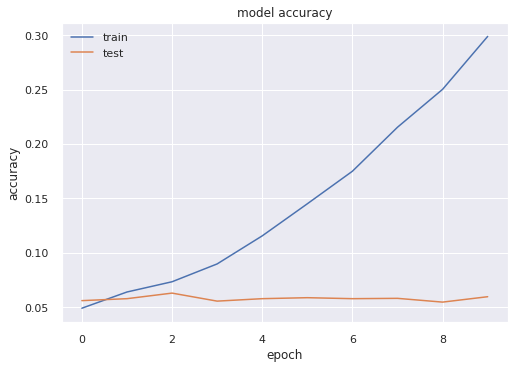

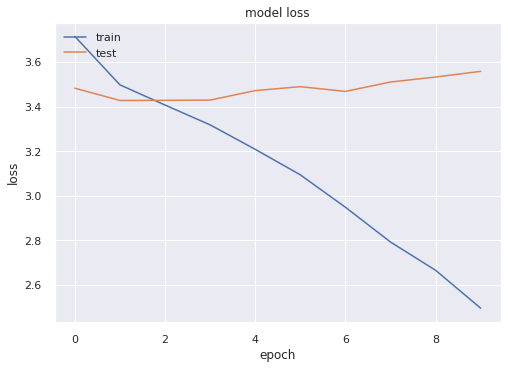

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?

**Resposta:** Para o dataset de **treino** temos uma tendência positiva para a acurácia e negativa para a função de erro. Para o dataset de **teste** não identificamos tendência para acurácia, enquanto temos uma leve subida na tendência da função de erro.

Os comandos abaixo são de referência para carregar um modelo para inferências futuras.

In [ ]:
%ls

projeto/  README.md


In [ ]:
%cd ..

/content


In [ ]:
%cd drive/My\ Drive/VisaoComputacional

/content/drive/My Drive/VisaoComputacional


In [ ]:
# carregando o modelo no formato HDf5
modelo_idade = load_model("projeto/modelos/modelo_idade.h5")  
modelo_idade.load_weights("projeto/pesos/modelo_idade_pesos.h5")

Este classificador tem uma particularidade diferente quando comparado com outros classificadores.
Geralmente um classificador retorna, dado uma amostra, qual a classe mais próxima ou qual tem maior probabilidade estatística. Por exemplo, se fóssemos classificar um objeto, o retorno seria a classe correspondente àquele objeto com maior semelhança, mutualmente excludente, sendo uma única classe como resultado.

Neste caso é diferente.

Cada classe se refere a uma idade, logo, ao invés de nos basearmos na classe dominante, com maior probabilidade, podemos somar as probabilidades com cada classe e assim ter um valor de idade mais aproximado (veja na imagem abaixo do pipeline, item 5). 

É por essa razão que a acurácia do modelo, baseada somente na classe dominante é baixa.

<p align="center">
<img src="https://github.com/michelpf/fiap-ml-visao-computacional-capstone/blob/master/projeto/imagens-aux/pipeline.png?raw=1">
</p>

Os comandos abaixo contabilizam a predição baseada na soma das probabilidades de cada classe.

In [ ]:
predicoes_idade = modelo_idade.predict(teste_x)
classes_idade_saida = np.array([i for i in range(0, classes_idade)])
predicoes_agrupadas = np.sum(predicoes_idade * classes_idade_saida, axis = 1)

Deste modo, o valor da acurácia não é o melhor para avaliarmoso modelo. A uma outra forma de avaliação é utilizarmos o _Erro Médio Absoluto_.

O uso do _Erro Médio Absoluto_ foi integralmente aplicado de acordo com este [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

In [ ]:
erro_medio_absoluto = 0
atual_media = 0

for i in range(0 ,predicoes_agrupadas.shape[0]):
    predicao = int(predicoes_agrupadas[i])
    atual = np.argmax(teste_y[i])
    erro_abs = abs(predicao - atual)
    atual_media = atual_media + atual
    erro_medio_absoluto += erro_abs

In [ ]:
erro_medio_absoluto /= predicoes_agrupadas.shape[0]
 
print("Erro médio absoluto (+/-): ", erro_medio_absoluto, " anos")
print("Exemplos analisados: ",predicoes_agrupadas.shape[0])

Erro médio absoluto (+/-):  3.6367058115025594  anos
Exemplos analisados:  6642


> **Critério de sucesso:** com base nas amostras de teste, o erro absoluto precisa ser não mais do que (+/-) 8.

Treinando a nova CNN com 10 épocas e batch size = 64, temos o **Erro absoluto** de (+/-) 3.63 anos, portanto, dentro do critério de sucesso exigido.

### 2.7 Avaliação final

Vamos analisar um conjunto de 6 imagens e verificar a coerência do modelo.
Antes precisamos contruir uma função, a ```carregarImagem``` para padronizar a imagem, redimensionando para o formato do modelo e normalizando a intensidade dos pixels.

In [ ]:
def carregarImagem(caminho):
    imagem = image.load_img(caminho, target_size=(224, 224))
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    imagem /= 255
    return imagem

Para cada imagem de testes já separadas no diretório ```testes```, vamos padronizá-la.

In [ ]:
caminho_imagem_1 = "projeto/testes/teste-1.jpg"
imagem_1_pad = carregarImagem(caminho_imagem_1)

Executar a inferência para obter sua predição.

In [ ]:
predicao_1 = modelo_idade.predict(imagem_1_pad)

E, finalmente, somar as classes para a classificação mais exata.

In [ ]:
idade_agrupada_1 = np.round(np.sum(predicao_1 * classes_idade_saida, axis = 1))

A função abaixo é para exibirmos no gráfico. Como elas estão com tamanhos diferentes, vamos também redimensioná-las para o padrão do moodeo, apenas por convenção, poderia ser outro tamanho.

In [ ]:
imagem_1 = image.load_img(caminho_imagem_1, target_size=(224, 224))

Agora, faremos para todas as outras imagens.

In [ ]:
caminho_imagem_2 = "projeto/testes/teste-2.png" 
imagem_2_pad = carregarImagem(caminho_imagem_2)
imagem_2 = image.load_img(caminho_imagem_2, target_size=(224, 224))
predicao_2 = modelo_idade.predict(imagem_2_pad)
idade_agrupada_2 = np.round(np.sum(predicao_2 * classes_idade_saida, axis = 1))

caminho_imagem_3 = "projeto/testes/teste-3.png"
imagem_3_pad = carregarImagem(caminho_imagem_3)
imagem_3 = image.load_img(caminho_imagem_3, target_size=(224, 224))
predicao_3 = modelo_idade.predict(imagem_3_pad)
idade_agrupada_3 = np.round(np.sum(predicao_3 * classes_idade_saida, axis = 1))

caminho_imagem_4 = "projeto/testes/teste-4.png"
imagem_4_pad = carregarImagem(caminho_imagem_4)
imagem_4 = image.load_img(caminho_imagem_4, target_size=(224, 224))
predicao_4 = modelo_idade.predict(imagem_4_pad)
idade_agrupada_4 = np.round(np.sum(predicao_4 * classes_idade_saida, axis = 1))

caminho_imagem_5 = "projeto/testes/teste-5.png"
imagem_5_pad = carregarImagem(caminho_imagem_5)
imagem_5 = image.load_img(caminho_imagem_5, target_size=(224, 224))
predicao_5 = modelo_idade.predict(imagem_5_pad)
idade_agrupada_5 = np.round(np.sum(predicao_5 * classes_idade_saida, axis = 1))

caminho_imagem_6 = "projeto/testes/teste-6.png"
imagem_6_pad = carregarImagem(caminho_imagem_6)
imagem_6 = image.load_img(caminho_imagem_6, target_size=(224, 224))
predicao_6 = modelo_idade.predict(imagem_6_pad)
idade_agrupada_6 = np.round(np.sum(predicao_6 * classes_idade_saida, axis = 1))

Exibindo as imagens.

O resultado da idade é índice 0 do objeto ```idade_agrupada```.

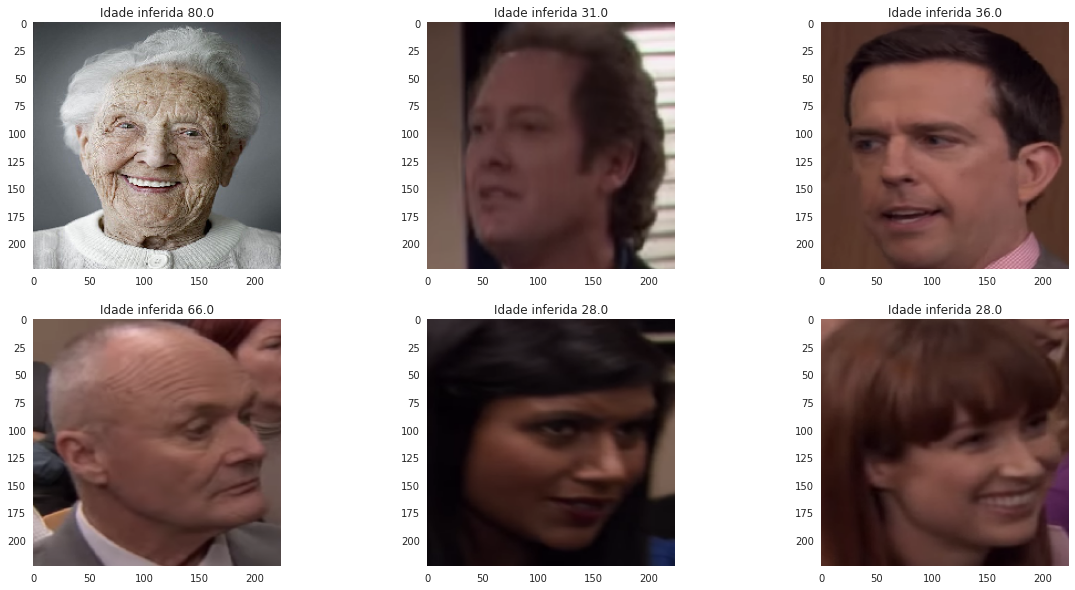

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Idade inferida " + str(idade_agrupada_1[0]))
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Idade inferida " + str(idade_agrupada_2[0]))
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Idade inferida " + str(idade_agrupada_3[0]))
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Idade inferida " + str(idade_agrupada_4[0]))
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Idade inferida " + str(idade_agrupada_5[0]))
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Idade inferida " + str(idade_agrupada_6[0]))
plt.imshow(imagem_6)

plt.show()

Analise se as idades estão coerentes com as imagens. Se estiver muito fora, avalie aumentar o número de épocas, por exemplo.

Agora vamos implementar a função que retornará a idade a partir de uma imagem de entrada já padronizada (assuma que foi padronizada por uma função como a ```carregarImagem```. Assegure que a função retorne o valor da idade inferida em valor numérico, sem valor fracionário, somente inteiro.

A princípio a idade do personagem Robert California, interpretado pelo ator James Spader está fora, o modelo nos forneceu a idade de 31 anos, porém olhando para sua aparência julgamos que este possui por volta de 40 anos.

In [ ]:
def predizerIdade(imagem):
    # IMPLEMENTAR
    classes_idade_saida = np.array([i for i in range(0, classes_idade)])
    predicao = modelo_idade.predict(imagem)
    return int(np.round(np.sum(predicao * classes_idade_saida, axis = 1)))

In [ ]:
# predizer a idade de uma pessoa através de sua imagem
predizerIdade(imagem_1_pad)

80

In [ ]:
# teste de aplicação da função que retorna a idade da pessoa na imagem com
# as nossas imagens de teste
imagens = [imagem_1_pad,
           imagem_2_pad,
           imagem_3_pad,
           imagem_4_pad,
           imagem_5_pad,
           imagem_6_pad]
                    
for imagem in tqdm(imagens):
  print('Idade: ', predizerIdade(imagem))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


Idade:  80
Idade:  31
Idade:  36
Idade:  66
Idade:  28
Idade:  28



Vamos usar as funções **carregarImagem** e **predizerIdade** para testar a idade de outros personagens interpretados pelo ator James Spader, o mesmo que interpreta o personagem Robert California em The Office. Começando pelo personagem Alan Shore, do seriado Boston Legal:

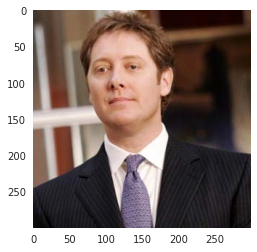

In [ ]:
imagem_plot_1 = cv2.imread("projeto/testes/alan-shore.jpg")
imagem_plot_1 = cv2.cvtColor(imagem_plot_1, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_plot_1);

In [ ]:
caminho_imagem_1_james_spader = "projeto/testes/alan-shore.jpg"
imagem_1_james_spader = carregarImagem(caminho_imagem_1_james_spader)
predizerIdade(imagem_1_james_spader)

44

Para este personagem nosso modelo previu a idade de 44 anos, o que julgamos um pouco exagerado em relação a imagem, daríamos em torno de 33 anos ou menos para esta imagem eum julgamento totalmente humano arbitrário. Mas de fato é possível nota que nesta imagem ele aparenta estar mais novo que seu personagem em The Office previsto mais acima com 31 anos.

Agora vamos novamente testar o modelo para o mesmo ator, agora interpretando o personagem Raymond Reddington do seriado The Blacklist:

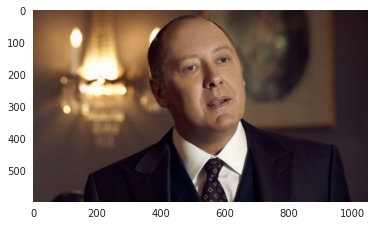

In [ ]:
imagem_plot_2 = cv2.imread("projeto/testes/The-Blacklist.jpg")
imagem_plot_2 = cv2.cvtColor(imagem_plot_2, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_plot_2);

In [ ]:
caminho_imagem_2_james_spader = "projeto/testes/The-Blacklist.jpg"
imagem_2_james_spader = carregarImagem(caminho_imagem_2_james_spader)
predizerIdade(imagem_2_james_spader)

54

Mais uma vez julgando a imagem de forma humana e arbitrária, podemos notar que dessa vez o modelo se sai melhor do que com o outro personagem, predizendo a idade de 54 anos.

Agora, vamos testar o que o modelo prediz quando o personagem Raymond Reddington está de chapéu:

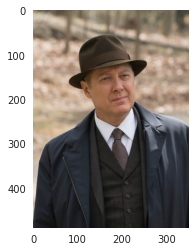

In [ ]:
imagem_plot_2 = cv2.imread("projeto/testes/reddington.png")
imagem_plot_2 = cv2.cvtColor(imagem_plot_2, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_plot_2);

In [ ]:
caminho_imagem_3_james_spader = "projeto/testes/reddington.png"
imagem_3_james_spader = carregarImagem(caminho_imagem_3_james_spader)
predizerIdade(imagem_3_james_spader)

25

Para este caso, o mesmo personagem, Raymond Reddington, o modelo previu 25 anos ao invés de 54. Nas imagens usadas para treinar o modelo existem imagens de pessoas usando boné, chapéu e óculos escuros, tando do sexo masculino quanto do sexo feminino, porém, provavelmente não na quantidade ideal a ponto da rede identificar com precisão a idade de pessoas de chapeu.


Liberando memória de variáveis sem utilização.

In [ ]:
treinamento_x, teste_x, treinamento_y, teste_y  = None, None, None, None

## 3. Modelo de predição de gênero biológico

A base utilizada será a mesma que aplicamos no modeo de idade. Nesse o caso o modelo terá uma tarefa mais fácil, pois ao invés de aproximidamente 100 classes vamos ter somente 2 classes, uma cada definir o gênero masculino e outra para o gênero feminino. 

### 3.1 Definição do modelo
Vamos começar definindo o número de classes.

In [ ]:
# IMPLEMENTAR
num_classes_genero = 2

Transformando os valores do conjunto de dados em _one hot enconding_ para definição dos gêneros.

In [ ]:
%ls

fiap-ml-visao-computacional-capstone/  imagens.zip  projeto/  README.md


In [ ]:
%cd ..

/content/drive/My Drive


In [ ]:
%cd ..

/content/drive


In [ ]:
%cd ..

/content


In [ ]:
%ls

drive/  fiap-ml-visao-computacional-capstone/  sample_data/


In [ ]:
%cd fiap-ml-visao-computacional-capstone/

/content/fiap-ml-visao-computacional-capstone


In [ ]:
from tqdm import tqdm_notebook as tqdm

tamanho_imagem = (224, 224)
faces = []

for index, row in tqdm(df.iterrows()):
    image_face = image.load_img("projeto/imagens/%s" % ast.literal_eval(row["full_path"])[0], grayscale=False, target_size=tamanho_imagem)
    image_array = image.img_to_array(image_face).reshape(1, -1)[0]
    image_array /= 255
    faces.append(image_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
features_imagem = []

features_imagem = np.array(faces)
features_imagem = features_imagem.reshape(features_imagem.shape[0], 224, 224, 3)

In [ ]:
features_imagem.shape

(22138, 224, 224, 3)

Liberar memória após o uso das imagens serem padronizadas.

In [ ]:
faces = None

In [ ]:
generos = df['gender']
generos_classes = keras.utils.to_categorical(generos, num_classes_genero)

Como para ambos os modelos, de idade e gênero, utilizamos a mesma base de _transfer learning_ do VGGFace, vamos reutilizá-la também neste modelo.

In [ ]:
%ls

projeto/  README.md


In [ ]:
%cd ..

/content


In [ ]:
%cd drive/My\ Drive/VisaoComputacional

/content/drive/My Drive/VisaoComputacional


In [ ]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()
saida_modelo = Convolution2D(num_classes_genero, (1, 1), name='predictions')(modelo.layers[-4].output)
saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)

modelo_genero = Model(inputs=modelo.input, outputs=saida_modelo)

### 3.2 Separação de dados de treinamento e validação

É recomendavel manter a mesma porcentagem do modelo anterior para dividir os dados de treinamento e validação.

In [ ]:
#IMPLEMENTAR
porcentagem_validacao = 0.3

In [ ]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  generos_classes, 
                                                                  test_size=porcentagem_validacao)

Liberando memória da variável ```features_imagem``` que não será utilizada.

In [ ]:
features_imagem = None

### 3.3 Treinamento e validação

A seguir iremos treinar o modelo para classificação de gêneros.
De forma semelhante realizada anteriormente, é necessário definir o número de épocas para esta etapa. Recomendamos um valor mínimo de 2.

In [ ]:
# IMPLEMENTAR
# numero_epocas = 10
numero_epocas = 4

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```*.

Este modelo é mais simples por ter menos classes, logo podemos assumir um ```batch_size``` maior que o anterior.

In [ ]:
modelo_genero.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico_genero = modelo_genero.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=64)

Epoch 1/4
243/243 [==============================] - 2008s 8s/step - loss: 0.1264 - accuracy: 0.9550 - val_loss: 0.0762 - val_accuracy: 0.9721
Epoch 2/4
243/243 [==============================] - 2088s 9s/step - loss: 0.0746 - accuracy: 0.9748 - val_loss: 0.0937 - val_accuracy: 0.9675
Epoch 3/4
243/243 [==============================] - 2300s 9s/step - loss: 0.0545 - accuracy: 0.9824 - val_loss: 0.0810 - val_accuracy: 0.9758
Epoch 4/4
243/243 [==============================] - 2251s 9s/step - loss: 0.0470 - accuracy: 0.9846 - val_loss: 0.0901 - val_accuracy: 0.9758


Salve os modelos abaixo para uso em inferências mais adiante no projeto.

In [ ]:
# Salvando o modelo no formato HDf5
modelo_genero.save("projeto/modelos/modelo_genero_four_epoch.h5")
modelo_genero.save_weights("projeto/pesos/modelo_genero_pesos_four_epoch.h5")

Verifique abaixo, por meio dos gráficos, como está a evolução da função de erro e acurácia do modelo.

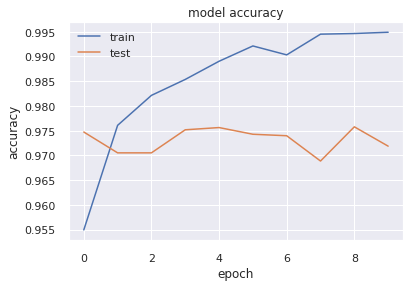

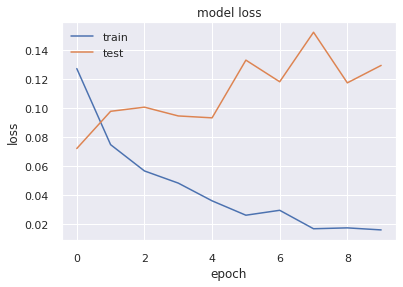

In [ ]:
# 10 épocas
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico_genero.history['accuracy'])
plt.plot(historico_genero.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico_genero.history['loss'])
plt.plot(historico_genero.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

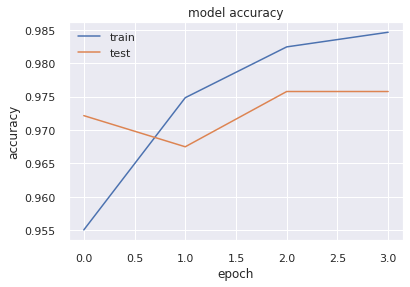

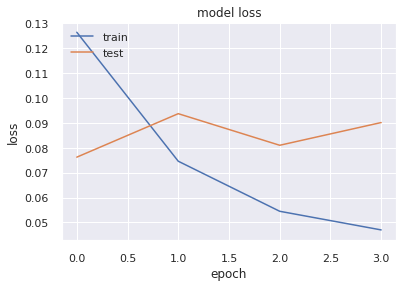

In [ ]:
# 4 épocas
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico_genero.history['accuracy'])
plt.plot(historico_genero.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico_genero.history['loss'])
plt.plot(historico_genero.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?

**Resposta:** Para a classificação do sexo da pessoa através da imagem do rosto treinamos a rede com 10 épocas. O gráfico da acurácia mostra tendencia de alta no dataset de treino, porém no dataset de teste a curva estabiliza após 4 épocas (sem tendência), tendo um pico de alta na oitava época e caindo novamente na nona e décima época. Ao testar o modelo com as imagens tivemos uma discrepância ao identificar o sexo do personagem **Robert California** (o mesmo que apresentou diferença de na identificação da idade), que teve como resultado sexo feminino. Além disso a função de erro no dataset de teste teve uma tendência de alta, totalmente oposto a curva da acurácia para o dataset de treino, mostrando claramente que o treinamento com 10 épocas "passou do ponto" e causou overfit do modelo. Para resolver isso fizemos um novo treinamento (com o cuidado de reiniciar o ambiente de trabalho, já que o Keras recomeça o treinamento da rede de onde parou) dessa vez com **4 épocas**, como citado anteriormente foi após a quarta época que notamos a estabilização da curva de acurácia do dataset de teste. Para o novo treinamento foi mantido o batch size = 64. Como resultado, além de obviamente levar menos tempo para treinar a rede, obtivemos estabilidade na funçao de erro do dataset de teste e a curva de acurácia deste conseguiu acompanhar a tendência de alta da acurácia do dataset de treino. Ao testar o modelo treinado com 4 épocas o personagem Robert California foi identificado corretamente como sexo masculino (e as demais imagens mantiveram a classificação correta).

Os comandos a seguir são para carregar os pesos e o modelo previamente treinado.

In [ ]:
# carregando o modelo no formato HDf5
modelo_genero = load_model("projeto/modelos/modelo_genero_four_epoch.h5")  
modelo_genero.load_weights("projeto/pesos/modelo_genero_pesos_four_epoch.h5")

> **Critério de sucesso:** acurácia do modelo, com base nas amostra de teste, superior a 95%.

### 3.4 Avaliação final

Com base em algumas amostras da base de testes, vamos inferir 6 imagens para verificarmos o desempenho do modeo.
Selecionamos 3 imagens de homens e mulheres.

Como este modelo é mais simples, ou seja, o resultado sempre vai ser a classe com maior probabilidade, não precisamos realizar a somatória dos pesos individualmente como fizemos no modelo anterior.

Assim o resultado final será obtido pela maior classe. A função ```np.argmax``` retorna a maior classe da predição realizada pelo modelo.

De acordo com o _encoding_, o índice 0 indica gênero masculino e o índice 1 o gênero feminino.

In [ ]:
predicao_1 = modelo_genero.predict(imagem_1_pad)
resultado_1 = "Masculino" if np.argmax(predicao_1) == 1 else "Feminino"

predicao_2 = modelo_genero.predict(imagem_2_pad)
resultado_2 = "Masculino" if np.argmax(predicao_2) == 1 else "Feminino"

predicao_3 = modelo_genero.predict(imagem_3_pad)
resultado_3 = "Masculino" if np.argmax(predicao_3) == 1 else "Feminino"

predicao_4 = modelo_genero.predict(imagem_4_pad)
resultado_4 = "Masculino" if np.argmax(predicao_4) == 1 else "Feminino"

predicao_5 = modelo_genero.predict(imagem_5_pad)
resultado_5 = "Masculino" if np.argmax(predicao_5) == 1 else "Feminino"

predicao_6 = modelo_genero.predict(imagem_6_pad)
resultado_6 = "Masculino" if np.argmax(predicao_6) == 1 else "Feminino"

Agora vamos exibir no gráfico as imagens e as inferências realizadas.

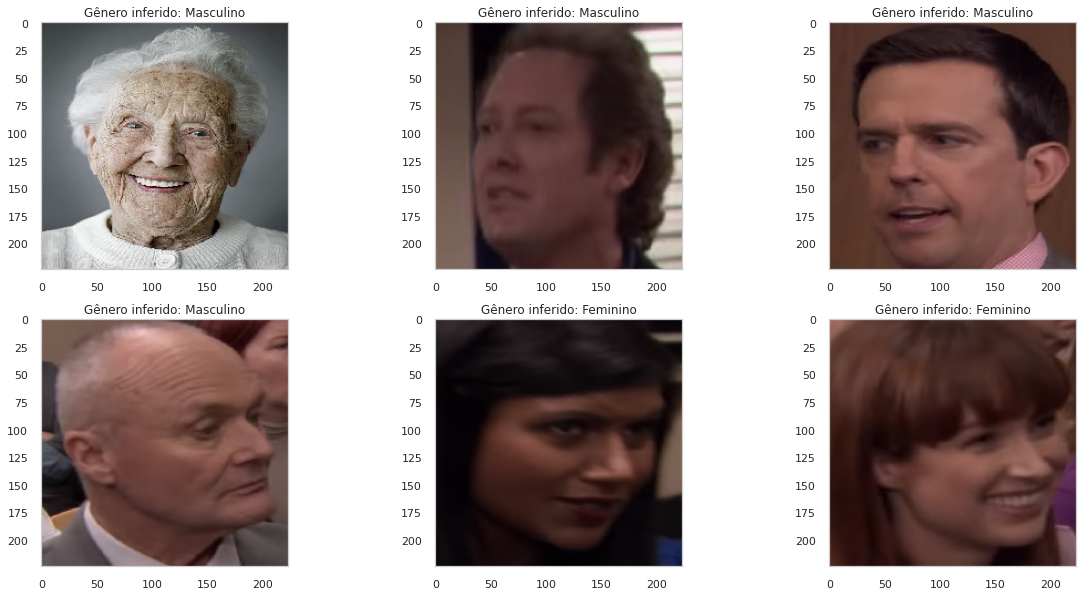

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Gênero inferido: " + resultado_1)
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Gênero inferido: " + resultado_2)
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Gênero inferido: " + resultado_3)
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Gênero inferido: " + resultado_4)
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Gênero inferido: " + resultado_5)
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Gênero inferido: " + resultado_6)
plt.imshow(imagem_6)

plt.show()

Vamos aproveitar para deixar preparado a função de predição de gênero para usarmos mais adiante.
Implemente a função abaixo para retornar "Masculino" se a classe com maior probabilidade for 1, ou "Feminino" se a maior probabilidade for a classe igual a 0.
É do mesmo jeito que fizemos anteriormente na predição de idade. Assuma que o parâmetro de entrada seja uma imagem já padronizada.

In [ ]:
def predizerGenero(imagem):
    # IMPLEMENTAR
    predicao = modelo_genero.predict(imagem)
    return "Masculino" if np.argmax(predicao) == 1 else "Feminino"

In [ ]:
# predizer a idade de uma pessoa através de sua imagem (personagem Robert California)
predizerGenero(imagem_2_pad)

'Masculino'

In [ ]:
# teste de aplicação da função que retorna a idade da pessoa nas imagens de teste
imagens = [imagem_1_pad,
           imagem_2_pad,
           imagem_3_pad,
           imagem_4_pad,
           imagem_5_pad,
           imagem_6_pad
           ]
           
for imagem in tqdm(imagens):
  print('Genero: ', predizerGenero(imagem))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


Genero:  Masculino
Genero:  Masculino
Genero:  Masculino
Genero:  Masculino
Genero:  Feminino
Genero:  Feminino



Liberando memória de variáveis sem utilização.

In [ ]:
treinamento_x, teste_x, treinamento_y, teste_y  = None, None, None, None

## 4. Identificação de faces

Nesta etapa precisamos construir uma forma de extrair regiões de interesse de imagens que sejam rostos. 
Problema de reconhecimento de faces aprofundado é realizada a partir de um recorte de região de interesse. Logo, nossa estratégia agora é como extrair uma ou mais faces de uma imagem para que seja possível, posteriormente, aplicarmos os modelos que acabamos de classificar.

Vamos começar com um teste simples.

In [ ]:
%ls

fiap-ml-visao-computacional-capstone/  imagens.zip  projeto/  README.md


In [ ]:
%cd /content/drive/My Drive/VisaoComputacional

/content/drive/My Drive/VisaoComputacional


In [ ]:
%ls

fiap-ml-visao-computacional-capstone/  imagens.zip  projeto/  README.md


In [ ]:
imagem = cv2.imread('projeto/testes/teste-8.png')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

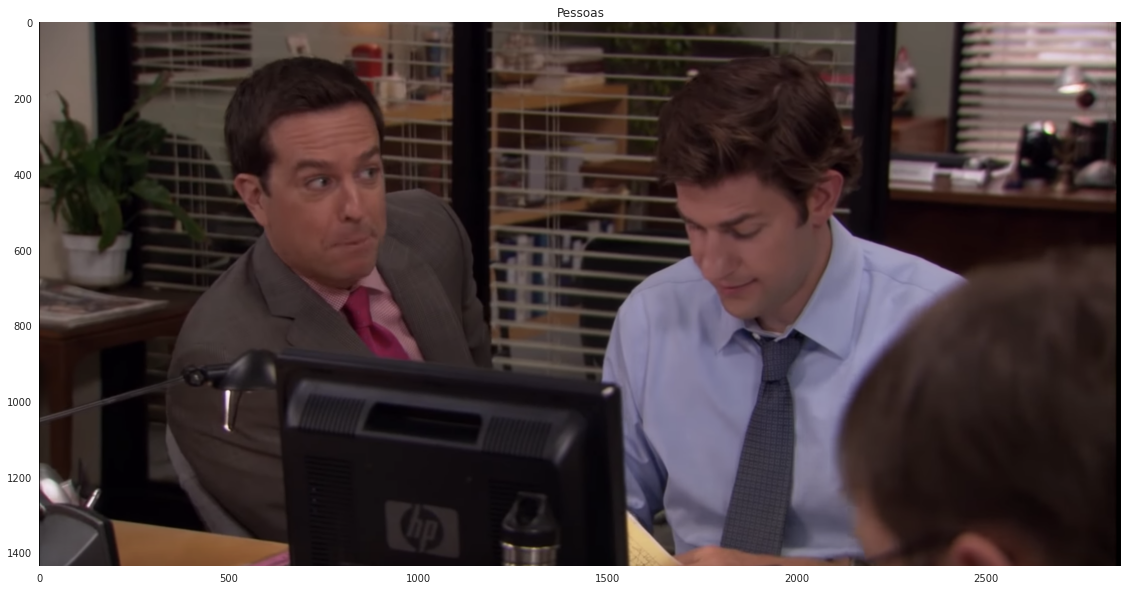

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Pessoas");

Escolha uma forma de identificar rostos de uma imagem.
Recomendamos as seguintes formas:

* Classificador em cascata de Haar
* Detector de face baseado em Hog (DLib), recomendamos utilizar o classificador de 68 pontos para maior precisão

Dada a imagem de testes apresentada, execute seu algoritmo escolhido e retorne o número de faces na variável ```faces```.

In [ ]:
# IMPLEMENTAR - Haar
classificador_haar = cv2.CascadeClassifier('projeto/classificadores/haarcascade_frontalface_default.xml')
faces = classificador_haar.detectMultiScale(imagem, 1.3, 5)

In [ ]:
print("Faces encontradas: " + str(len(faces)))

Faces encontradas: 1


In [ ]:
faces

array([[551, 240, 430, 430]], dtype=int32)

In [ ]:
# IMPLEMENTAR - Hog(DLib)
classificador_68_path = 'projeto/classificadores/shape_predictor_68_face_landmarks.dat'
classificador_dlib_68 = dlib.shape_predictor(classificador_68_path)
detector_dlib = dlib.get_frontal_face_detector()


faces = detector_dlib(imagem,1)  

In [ ]:
print("Faces encontradas: " + str(len(faces)))

Faces encontradas: 2


In [ ]:
faces

rectangles[[(589, 290) (974, 675)], [(1668, 455) (1989, 776)]]

> **Critério de sucesso:** encontrar as 2 faces da imagem.

Com as faces identificadas, desenhe um retângulo em cada uma delas.
Para desenhar um retângulo, é necessário os seguintes dados: coordenada x, y, comprimento (w) e altura (h).

Caso utilize o detector de faces do DLib, o valor da coordenada x é equivalente ao atributo _left_ e a coordenada y é o equivalente ao atributo _top_.

O DLib é um identificador tão versátil que é capaz de identificar rostos parciais em uma imagem. No entanto, quando isso ocorre as coordenadas podem ser negativas, o que pode demandar um certo ajuste para obter o valor da região de interesse, por exemplo igualando a coordenada a 0.

Utilize o seguinte comando para desenhar um retângulo em cada face identificada.

````
cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)
````

Criando uma cópia da imagem original para anotação.

In [ ]:
imagem_anotada = imagem.copy()

In [ ]:
#IMPLEMENTAR - OpenCV Haar
for (x,y,w,h) in faces:
  cv2.rectangle(imagem_anotada, (x,y), (x+w, y+h), (255,255,0), 2)

In [ ]:
#IMPLEMENTAR - Dlib Hog
# obter as coordenadas no mesmo padrão do OpenCV
faces_ret = []
for i, face in enumerate(faces):
  faces_ret.append([face.left(),face.top(), face.width(), face.height()])

print('coordenadas: ', faces_ret)

for (x,y,w,h) in faces_ret:
  cv2.rectangle(imagem_anotada, (x,y), (x+w, y+h), (255,255,0), 2)

coordenadas:  [[589, 290, 386, 386], [1668, 455, 322, 322]]


Exibindo a imagem com os retângulos desenhados.

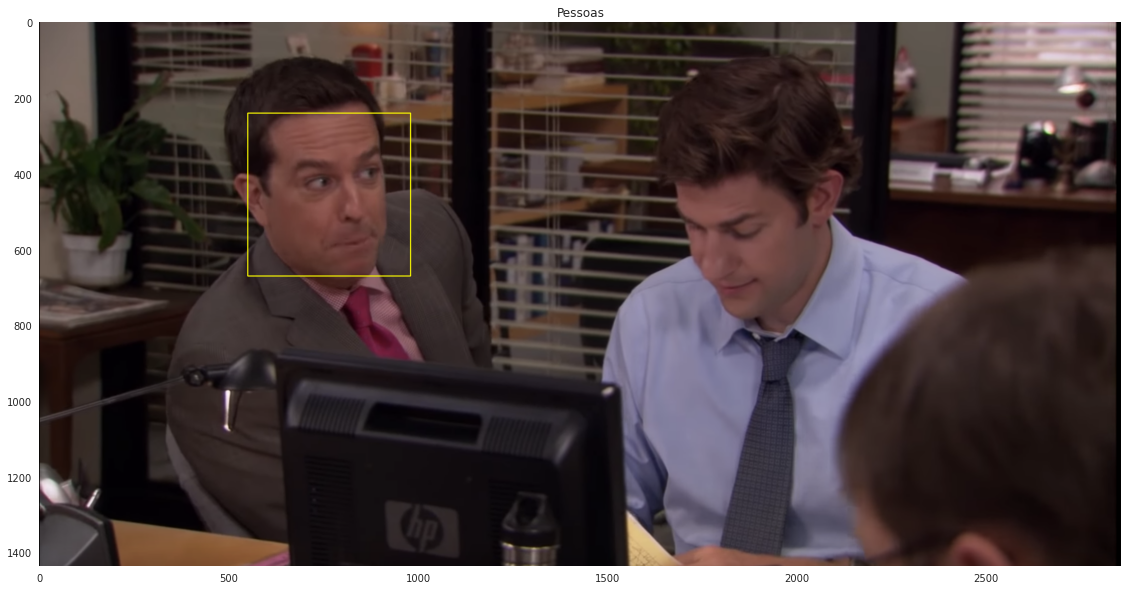

In [ ]:
# OpenCV - Classificador Haar 
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas");

O classificador de Haar do Open CV não identificou o rosto do personagem Jim Halpert mais a direta na imagem, provavelmente pelo fato dos olhos deste não estar aparecendo na imagem. Com a calibração do classificador para tentar encontrar até 5 rostos na imagem o classificador de fato só identifica o rosto do personagem Andy Bernard a esquerda da imagem. Quando calibramos para o classificador para tentar encontrar até 3 rostos este erra ao encontrar um "rosto" em uma pasta de arquivo (falso positivo).

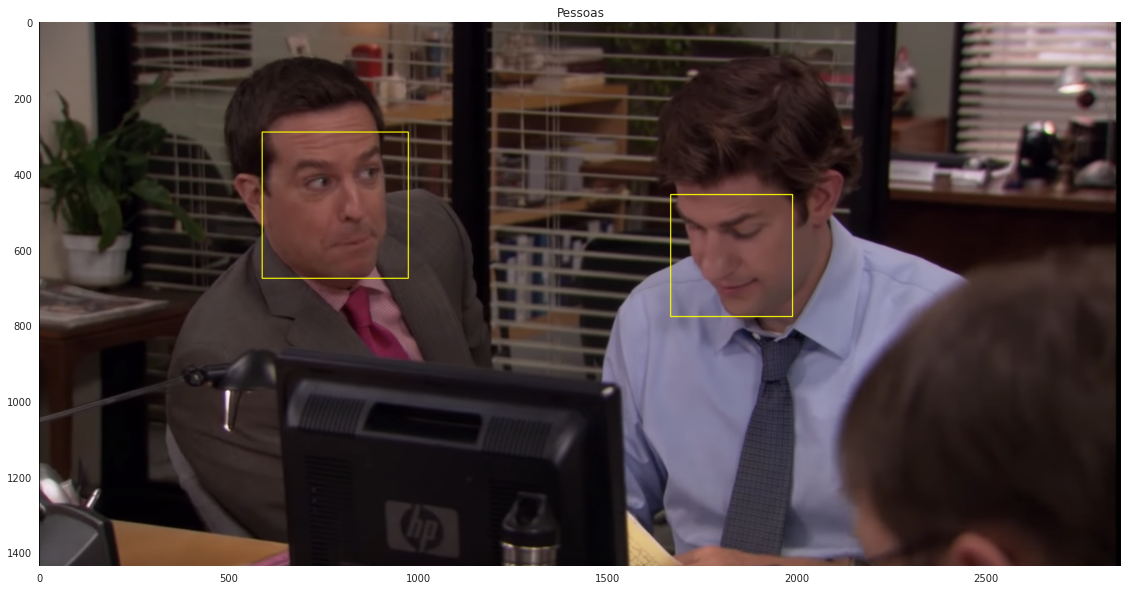

In [ ]:
# Dlib - Classificador Hog
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas");

O classificador Hog da biblioteca Dlib conseguiu identificar corretamente os rostos dos personagens Andy Bernard a esquerda e Jim Halpert a direita da imagem. O desempenho deste classificador é superior ao classificador Haar quanto a identificação dos rostos, porém ja sabemos que pode não se sair bem ao fazer a análise das imagens em tempo real por ter processamento mais lento em comparação ao classificador Haar, para tirar a dúvida testaremos os dois métodos para analisar o vídeo para comparar como cada um se sai na tarefa. 

--------------------------------------------------------

Uma vez que já foi definido o melhor algoritmo de identificação de faces, precisamos construir uma função que posteriormente utilizaremos no processo de processamento de vídeos.

Essa função deverá receber na entrada uma imagem colorida e retornar, na forma de lista, um dicionário com as seguintes informações: extração do ROI do rosto e as coordenadas da localização do rosto.

Exemplo de retorno:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'rosto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

O atributo rosto utilizaremos para aplicarmos os modelos de reconhecimento de idade e gênero, e as coordenadas serão utilizadas para fazer os recortes nas imagens.

Com isso, a chave ```rosto``` deverá ter o _slice_ da imagem neste padrão ```imagem[y:y+h, x:x+w]``` e a chave ```coordenadas``` deverá ter a saída dos pontos (x, y, h, w) neste padrão ```[np.array(lista_coordenadas)]```.

In [ ]:
# obterFaces usando Hog
def obterFacesHog(imagem):
    
    rostos = []
    faces = None
    
    #IMPLEMENTAR - HOG
    
    # 1) Identificação de rostos usando classificador Hog
    classificador_68_path = 'projeto/classificadores/shape_predictor_68_face_landmarks.dat'
    classificador_dlib_68 = dlib.shape_predictor(classificador_68_path)
    detector_dlib = dlib.get_frontal_face_detector()
    faces = detector_dlib(imagem,1)      

    # 2) Extrair as coordenadas x, y, w, h (em forma de lista)
    faces_ret = []
    for face in faces:
      x = face.left()
      y = face.top()
      w = face.width()
      h = face.height()
      
      coordenadas = [np.array((x,y,h,w))]
      
      # 3) Obter a região de interesse
      roi = imagem[y:y+h, x:x+w]

      # 4) Construir a lista com o dicionário dentro
      rostos.append({'coordenadas': coordenadas,'rosto': roi})
 
    # 5) retornar a lista com o dicionário dentro 
    return rostos

In [ ]:
faces

rectangles[[(589, 290) (974, 675)], [(1668, 455) (1989, 776)]]

In [ ]:
# obterFaces usando Haar
def obterFaces(imagem):
    
    rostos = []
    faces = None
    
    #IMPLEMENTAR - Haar
    
    # 1) Identificação de rostos usando classificador Haar
    faces = classificador_haar.detectMultiScale(imagem, 1.3, 5)      

    # 2) Extrair as coordenadas x, y, w, h (em forma de lista)
    for (x,y,w,h) in faces:
      # 3) Obter a região de interesse
      roi = imagem[y:y+h, x:x+w]
      # 4) Construir a lista com o dicionário dentro
      rostos.append({'coordenadas': np.array((x,y,w,h)),'rosto': roi})
 
    # 5) retornar a lista com o dicionário dentro 
    return rostos

Vamos aplicar um teste com a imagem anterior (variável ```imagem```).

In [ ]:
rostos = obterFaces(imagem)
rostos

[{'coordenadas': array([551, 240, 430, 430], dtype=int32),
  'rosto': array([[[ 37,  25,  26],
          [ 38,  25,  26],
          [ 38,  25,  26],
          ...,
          [110,  75,  50],
          [110,  75,  50],
          [110,  75,  50]],
  
         [[ 37,  25,  26],
          [ 38,  25,  26],
          [ 38,  25,  26],
          ...,
          [111,  75,  49],
          [110,  75,  49],
          [110,  75,  49]],
  
         [[ 37,  25,  26],
          [ 38,  25,  26],
          [ 38,  25,  26],
          ...,
          [111,  76,  49],
          [110,  75,  48],
          [110,  76,  48]],
  
         ...,
  
         [[ 39,  27,  28],
          [ 40,  28,  29],
          [ 41,  29,  30],
          ...,
          [ 60,  48,  47],
          [ 59,  47,  47],
          [ 59,  47,  46]],
  
         [[ 39,  27,  28],
          [ 40,  28,  29],
          [ 41,  29,  30],
          ...,
          [ 60,  48,  48],
          [ 61,  49,  48],
          [ 60,  48,  48]],
  
         [

In [ ]:
rostos = obterFacesHog(imagem)
rostos

[{'coordenadas': [array([589, 290, 386, 386])], 'rosto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],
  
         [[38, 20, 19],
          [39, 21, 19],
          [41, 22, 20],
          ...,
          [36, 18, 13],
          [37, 20, 15],
          [39, 22, 17]],
  
         [[37, 19, 18],
          [39, 20, 18],
          [41, 22, 20],
          ...,
          [36, 18, 13],
          [37, 20, 14],
          [39, 21, 16]],
  
         ...,
  
         [[57, 47, 49],
          [58, 47, 49],
          [58, 48, 49],
          ...,
          [61, 49, 48],
          [62, 50, 49],
          [63, 51, 50]],
  
         [[58, 48, 50],
          [59, 48, 50],
          [59, 49, 50],
          ...,
          [63, 51, 50],
          [63, 51, 50],
          [62, 50, 49]],
  
         [[58, 48, 50],
          [59, 49, 51],
          [60, 49, 50],
          ...,
          [63, 51, 50],
  

In [ ]:
len(rostos)

2

> **Critério de sucesso:** retornar 2 valores (da lista) com coordenadas e rosto para cada face identificada. Exemplo:


```
[{'coordenadas': [array([534, 20,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)},
  {'coordenadas': [array([222, 13,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)}]
```

Agora vamos testar se os parâmetros estão funcionando adequadamente.

Primeiro a imagem do rosto.

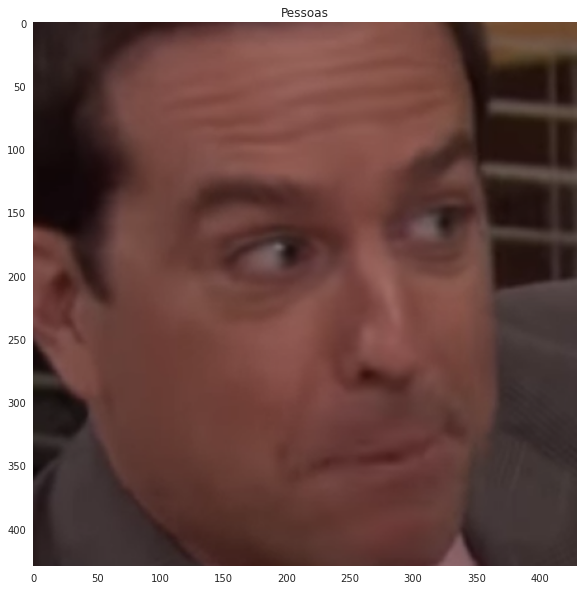

In [ ]:
# mostrar o primeiro rosto da imagem - Haar
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(rostos[0]["rosto"])
plt.title("Pessoas");

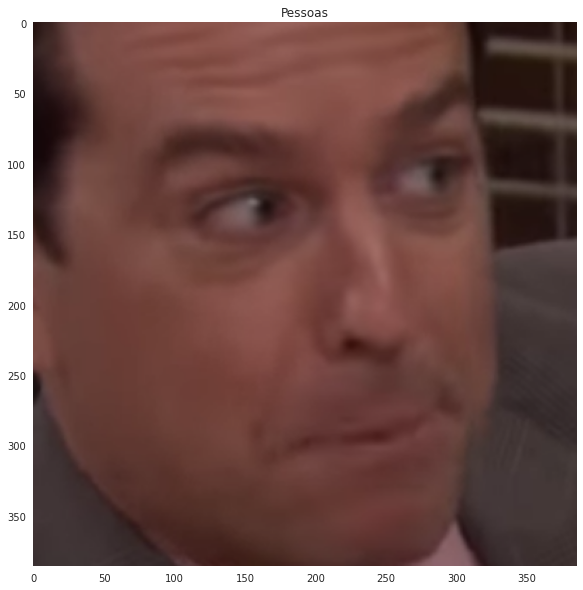

In [ ]:
# mostrar o primeiro rosto da imagem - Hog
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(rostos[0]["rosto"])
plt.title("Pessoas");

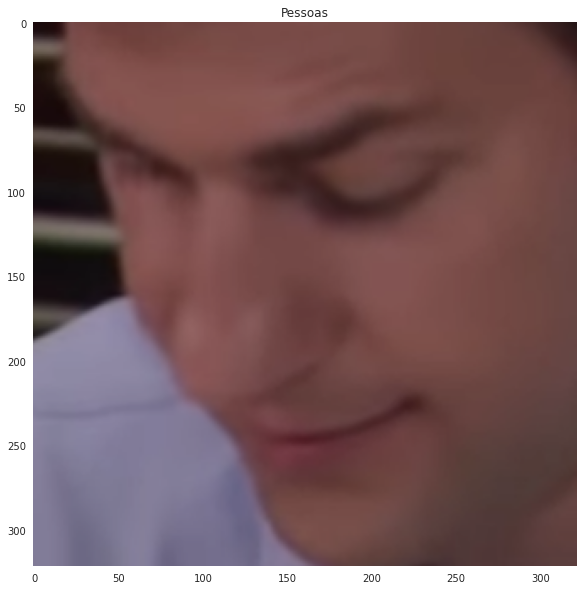

In [ ]:
# mostrar o segundo rosto da imagem - Hog
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(rostos[1]["rosto"])
plt.title("Pessoas");

O próximo passo são as coordenadas. Para simplificar, vamos desenhar um retângulo na imagem original com estes pontos.

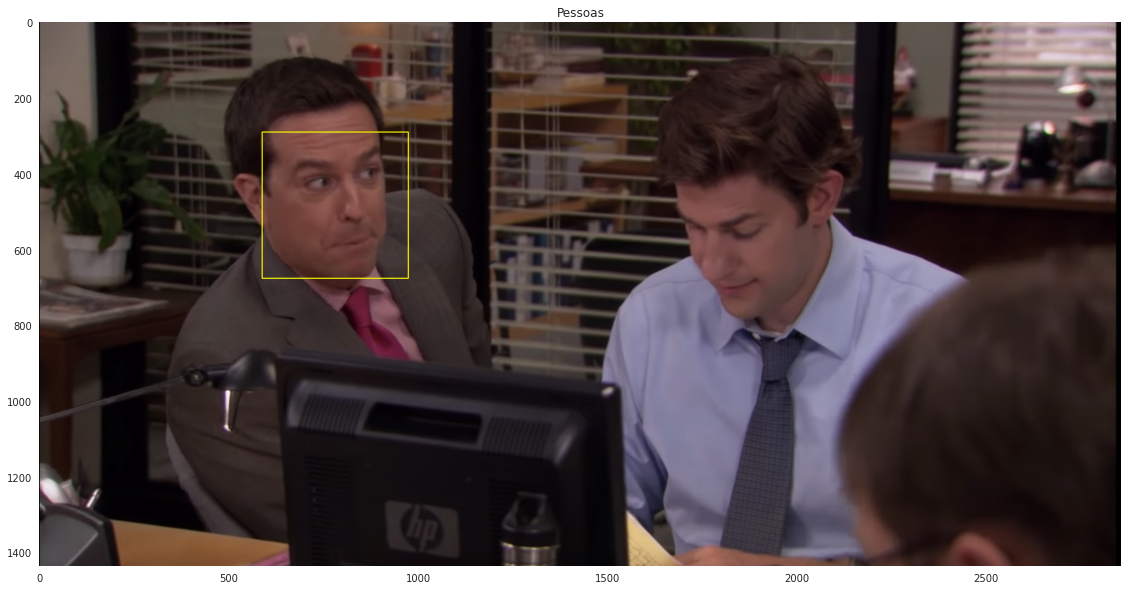

In [ ]:
# desenhar o retangulo no primeiro rosto - Hog
imagem_anotada = imagem.copy()

for (x,y,w,h) in rostos[0]['coordenadas']:
    cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas");

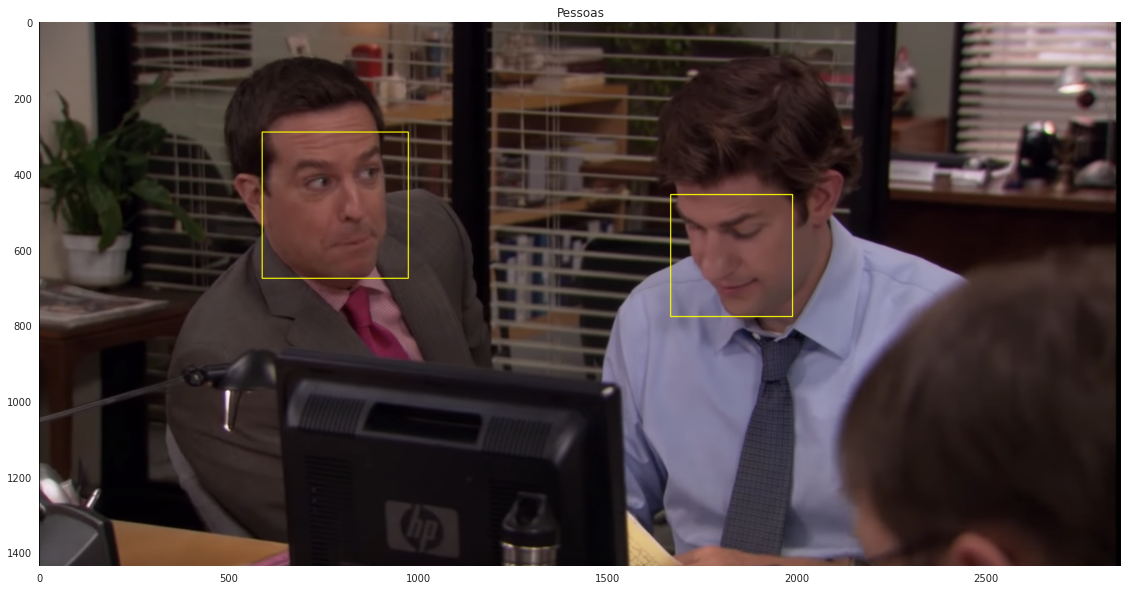

In [ ]:
# desenhar o retangulo no segundo rosto - Hog
for (x,y,w,h) in rostos[1]['coordenadas']:
    cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas");

### 4.1 Padronização de tamanho de imagem

Adiante, quando aplicarmos a classificação dos rostos, precisaremos antes padronizar a imagem para o tamanho que o modelo recebe na camada de entrada bem como a normalização dos pixels da imagem, ou seja, ao invés de estar no formato de intensidade de pixel de 0 a 255, deve estar representado entre 0 e 1.

As implementações deverão ser as seguintes:

1. ```IMPLEMENTAR 1```: redimensionar a imagem para o tamanho da camada de entrada. Utilize uma interpolação adequada para não perder qualidade de imagem.
2. ```IMPLEMENTAR 2```: normalizar a intensidade de pixel da imagem para 0 e 1 e não 0 a 255, que é o padrão.

As demais instruções seguem inalteradas.

In [ ]:
def padronizarROI(imagem):
    # IMPLEMENTAR 1
    novo_tamanho = (224,224)
    imagem = cv2.resize(imagem, novo_tamanho, interpolation=cv2.INTER_CUBIC)
        
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    
    # IMPLEMENTAR 2
    imagem /= 255
    
    return imagem

Shape imagem:  (1, 224, 224, 3)


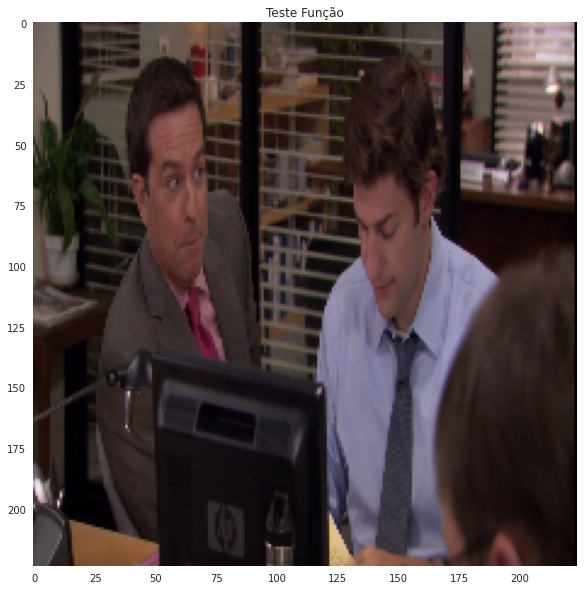

In [ ]:
# teste da função padronizarROI
padronizar = padronizarROI(imagem)
print('Shape imagem: ',padronizar.shape)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(padronizar[0])
plt.title("Teste Função");

Agora, vamos avançar para a identificação de objetos.

## 5. Identificação de objetos

Além de identificarmos as pessoas, precisamos também identificar diferentes objetos.
Uma forma de alcançarmos tal objetivo é utilizar um modelo já treinado com diversos objetos treinados.

O modolo Yolov3, por exemplo, possui 80 diferentes objetos em seu modelo, servindo muito bem para o propósito do desafio.

### 5.1 Configurando o modelo Yolov3

Primeiramente baixe os pesos diretamente no site do Darknet, neste [link](https://pjreddie.com/media/files/yolov3.weights). Copie o arquivo ```yolov3.weights``` para a pasta pesos.
Confira o arquivo ```yolo-classes/coco.names```. Estas são as classes de todos os objetos que são possíveis identificar.
Por fim, verifique se o arquivo ```config/yolov3.cfg``` está presente. Não é necessário ajustar nenhum parâmetro nele.

In [ ]:
%ls

fiap-ml-visao-computacional-capstone/  imagens.zip  projeto/  README.md


In [ ]:
# Carregar os labels do conjunto de dados Coco
label_path = "projeto/yolo-classes/coco.names"
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path ="projeto/pesos/yolov3.weights"
config_path = "projeto/config/yolov3.cfg"

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Se o código carregou as configurações sem erros, estamos prontos para avançar.

Os valores de confiança e supressão não máxima são atributos importantes para o processo de detecção de objetos. Escolha valores adequados que permitam a detecção aceitável e com valores próximos os critérios de sucesso apresentandos mais adiante.

Os valores precisam ser numéricos fracionários. Sendo que 1 é igual a 100%. Valores médios costumam apresentar performance razoável.

In [ ]:
# configuração para auditoria com o classificador Hog 
#conf_threshold = 0.7
# Ajuste de sensibilidade de imagens com baixa luminosidade
#nms_threshold  = 0.6

# configuração para auditoria com o classificador Haar
conf_threshold = 0.5

nms_threshold  = 0.4

**Pergunta:** Qual é a influência do parâmetro de confiança e supressão não máxima na performance do modelo?

**Resposta:** 
- Pelos testes realizados identificamos que quanto menos o **intervalo de confiança**, mais objetos são identificados, porém, é uma identificação que erra muito: um ombro de uma pessoa pode ser classificado como um objeto quando o parâmetro foi especificado em 0.3em que muitos frames do vídeo. Por outro lado, se o intervalo estiver com o valor muito alto, a identificação deixa passar objetos de interesse, como foi o caso em que configuramos o parâmetro com o valor 0.7 em que apenas 298 objetos foram identificados na auditoria, bem abaixo do valor 680, considerado referência para uma identificação bem sucedida.

- Quanto a **supressão não máxima** testamos dois valores diferentes para o parâmetro, primeiro em 0.6 (aliado ao ao valor de 0.7 do intervalo de confiança) e depois ajustando para o valor considerado padrão para o hiper parâmetro, no valor de 0.4. Este último, ajuda que objetos sejam identificados quando a luminosidade da imagem é mais baixa, o que é o caso do vídeo auditado neste projeto. Em configuração considerada padrão, com o nms = 0.4 e com o intervalo de confiança configurado no valor de 0.5, conseguimos atingir 684 objetos identificados no vídeo, atingindo o objetivo estipulado no projeto. 

### 5.2 Obtendo região de interesse e coordenadas

De forma semelhante que foi feito na identificação de faces, vamos fazer para a identificação de objetos.
Na função abaixo vamos implementar um algoritmo que retornará em um dicionário os valores do recorte da imagem, o que chamamos de região de interesse e suas coordenadas x, y, w e h.

A entrada da função é uma imagem colorida e uma lista de objetos para identificar, no formato de lista.
Sua saída, é uma lista de objetos no seguinte formato:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'objeto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

Onde ```coordenadas``` é uma lista das coordenadas x, y, w e h no formato array, igual ao que foi apresentado anteriormente: ```[np.array(lista_coordenadas)]```. E ```objeto``` é a região de interesse do objeto extraído, igual ao que foi apresentado anteriormente: ```imagem[y:y+h, x:x+w]```.

In [ ]:
def obter_objetos(imagem, lista_objetos):
    
    (H, W) = imagem.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(imagem, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    objetos = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            
            if labels[classIDs[i]] in lista_objetos:
                #print("Identificado " + text)
                
                # IMPLEMENTAR
                coordenadas = [np.array((x,y,w,h))]
                roi = imagem[y:y+h,x:x+w]

                item = {"objeto": roi, "coordenadas": coordenadas}
                
                objetos.append(item)

    return objetos

Vamos utilizar outra imagem de testes para validar o algoritmo.

In [ ]:
imagem_inferencia = cv2.imread("projeto/testes/teste-9.png")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)

Na variável ```lista_objetos``` preecha com uma lista de Strings com os valores "pessoa" e "gravata" que são os objetos a serem identificados.

In [ ]:
# IMPLEMENTAR
lista_objetos = ["pessoa", "gravata"]

Execute a função com a lista definida.

In [ ]:
objetos = obter_objetos(imagem_inferencia, lista_objetos)

In [ ]:
# saída da função obter_objetos
objetos

[{'coordenadas': [array([1178,  233,  526,  902])],
  'objeto': array([[[ 69,  64,  54],
          [ 69,  65,  55],
          [ 69,  65,  55],
          ...,
          [171, 165, 147],
          [174, 168, 150],
          [177, 171, 154]],
  
         [[ 69,  64,  54],
          [ 69,  65,  55],
          [ 69,  65,  55],
          ...,
          [168, 161, 143],
          [171, 165, 147],
          [175, 168, 151]],
  
         [[ 69,  64,  54],
          [ 69,  65,  55],
          [ 69,  65,  55],
          ...,
          [163, 157, 139],
          [167, 161, 144],
          [171, 165, 148]],
  
         ...,
  
         [[ 52,  42,  37],
          [ 51,  42,  37],
          [ 51,  41,  36],
          ...,
          [ 25,  17,  14],
          [ 25,  17,  14],
          [ 25,  17,  14]],
  
         [[ 52,  42,  37],
          [ 51,  42,  37],
          [ 51,  41,  37],
          ...,
          [ 25,  17,  14],
          [ 25,  17,  14],
          [ 25,  17,  14]],
  
         [[ 52, 

Para nos certificamos que a identificação está correta, vamos desenhar um retângulo delimitador na imagem e verificar como foi a identificação.

Neste caso vamos utilizar o parâmetro ```coordenadas``` do retorno da função para cada objeto identificado.

In [ ]:
imagem_anotada = imagem_inferencia.copy()
for obj in objetos:
    for (x,y,w,h) in obj["coordenadas"]:
        cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

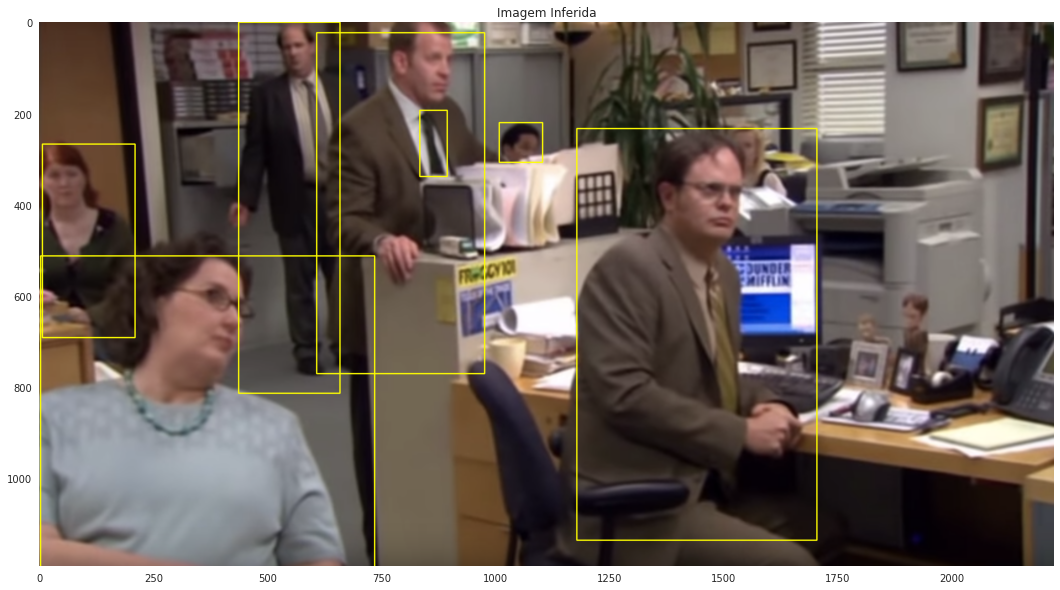

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Imagem Inferida");

Vamos dar uma olhada em 3 regiões de interesse detectadas.
Lembrando que estas regiões são imagens, podemos renderizá-las diretamente no Pyplot.

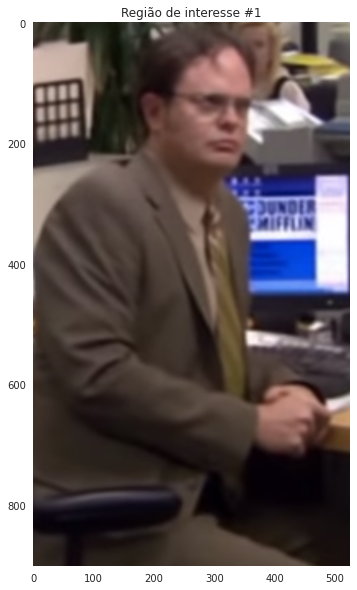

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[0]["objeto"])
plt.title("Região de interesse #1");

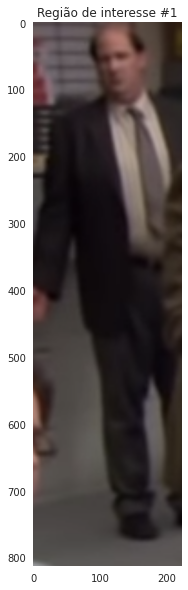

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[1]["objeto"])
plt.title("Região de interesse #1");

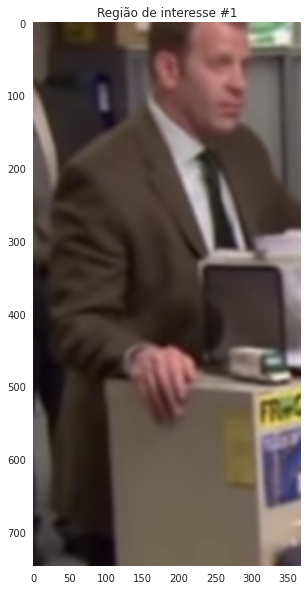

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[2]["objeto"])
plt.title("Região de interesse #1");

Perfeito, agora já estamos prontos para juntar todas as peças e começar nossa auditoria.

## 6. Auditoria automática em vídeo

Esta é a parte final do projeto.
Vamos fazer um checkpoint até aqui para ter certeza de que fizemos com sucesso os passos anteriores.

* <input type="checkbox" disabled checked> Modelo de detecção de idades treinado
* <input type="checkbox" disabled checked> Modelo de detecção de idades salvo
* <input type="checkbox" disabled checked> Modelo de detecção de idades carregado
* <input type="checkbox" disabled checked> Função de detecção de idades
* <input type="checkbox" disabled checked> Modelo de detecção de gênero treinado
* <input type="checkbox" disabled checked> Modelo de detecção de gênero salvo
* <input type="checkbox" disabled checked> Modelo de detecção de gênero carregado
* <input type="checkbox" disabled checked> Função de detecção de gênero
* <input type="checkbox" disabled checked> Função de padronização de imagens
* <input type="checkbox" disabled checked> Função de extração de faces
* <input type="checkbox" disabled checked> Função de extração de objetos

O que precisamos identificar no vídeo de auditoria:

* Homens com mais de 45 anos
* Mulheres com menos de 45 anos
* Objetos _computador portátil, celular, teclado, tv _ e _controle remoto_.

Vamos começar definindo a lista de objetos.

In [ ]:
lista_objetos = ['computador portátil', 'celular', 'teclado', 'tv', 'controle remoto']

Nesta parte vamos reunir tudo o que fizemos até aqui.
O algoritmo irá abrir um vídeo e, frame a frame, analisar seu conteúdo.
Após a instrução ```if is_capturing``` iremos implementar as verificações.

A execução abaixo pode demorar, pois será analisado individualmente cada frame do vídeo.

O que precisamos fazer:

* ```IMPLEMENTAR 1```: obter as faces de uma imagem. Neste caso receberamos uma lista de rostos no padrão que já vimos, ou seja, uma lista de ```rosto``` e ```coordenadas```.

* ```IMPLEMENTAR 2```: obter as a face de um item e padronizar. Lembre-se de utilizar a função de padronização que foi desenvolvida anteriormente, que tem por finalidade ajustar o tamanho da imagem e também normalizá-la.

* ```IMPLEMENTAR 3```: executar as funções de identificar a idade e gênero para a tomada de decisões de coleta de evidências.

* ```IMPLEMENTAR 4```: criar as regras de armazenamento de evidências para pessoas. Consulte as regras no início do projeto sobre quais os gêneros e idades de interesse. As regiões de interesse nesse caso, os rostos, deverão ser salvos individualmente na pasta ```resultado/homem``` e ```resultado/mulher```.

* ```IMPLEMENTAR 5```: criar as regras de armazenamento de evidências para objetos. As regiões de interesse nesse caso, os objetos, deverão ser salvos individualmente na pasta ```resultado/objetos```.

In [ ]:
%ls

drive/  fiap-ml-visao-computacional-capstone/  sample_data/


In [ ]:
%cd drive/My\ Drive/VisaoComputacional

/content/drive/My Drive/VisaoComputacional


In [ ]:
!rm -rf projeto/resultado/homem/
!rm -rf projeto/resultado/mulher/
!rm -rf projeto/resultado/objetos/

In [ ]:
!mkdir projeto/resultado/homem_hog/
!mkdir projeto/resultado/mulher_hog/
!mkdir projeto/resultado/objetos_hog/

In [ ]:
!mkdir projeto/resultado/homem/
!mkdir projeto/resultado/mulher/
!mkdir projeto/resultado/objetos/

In [ ]:
#cam.release() - usando Hog para identificação dos rostos
cam = cv2.VideoCapture("projeto/videos/video-1.avi")
contador = 0 

contador_masc   = 0
contador_femin  = 0
contador_objeto = 0
contador_frame  = 0
contador_fail_obj = 0

try:
    while(True):
        contador += 1
        is_capturing, imagem = cam.read()
        
        
        if is_capturing:
            
            # IMPLEMENTAR 1
            # Obter Faces - usando Hog
            faces = obterFacesHog(imagem)
            
            for idx, face in enumerate(faces):
                #print("Encontrado " + str(len(faces)) + " rostos...")
                
                # IMPLEMENTAR 2
                # Padronizar a imagem do rosto (ROI)
                # Obtenha a imagem do rosto da variável face e armazene em imagem_rosto
                # Depois utilize a função padronizarROI, com a variável imagem_rosto para obter
                # o rosto padronizado e armazenar em rosto_padronizado
                
                imagem_rosto = face['rosto']

                try:
                  rosto_padronizado = padronizarROI(imagem_rosto)
                
                  # IMPLEMENTAR 3
                  # Chame as funções para predizer gênero e idade com a imagem padronizada do rosto
                  
                  genero = predizerGenero(rosto_padronizado)
                  idade  = predizerIdade(rosto_padronizado)
                              
                  #print("Gênero: " + str(genero) + ", idade: " + str(idade))
                                  
                  # IMPLEMENTAR 4
                  # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                  # de acordo com o identificação (resultado/homem, resultado/mulher)
                  # Cuidado para não sobrescrever as imagens
                  
                  # aumentar em uma unidade o contador de imagens definido no
                  # início deste script
                  # associar os diretórios para salvar as imagens de homens com mais de 45 anos
                  # e mulheres com menos de 45 anos
                  
                  dir_masc  = 'projeto/resultado/homem_hog/'
                  dir_femin = 'projeto/resultado/mulher_hog/' 

                  # condição para salvar as evidências
                  if (genero == 'Masculino') and (idade > 45):
                    # salvar imagem no diretório
                    contador_masc += 1
                    img_masc  = dir_masc + str(contador_masc) + '.png'
                    cv2.imwrite(img_masc, imagem_rosto)
                    
                  elif (genero == 'Feminino') and (idade < 45):
                    # salvar imagem no diretório
                    contador_femin += 1
                    img_femin  = dir_femin + str(contador_femin) + '.png'
                    cv2.imwrite(img_femin, imagem_rosto)
                
                except:
                  contador_frame += 1
                  continue   

            try:

              objetos = obter_objetos(imagem, lista_objetos)

              # IMPLEMENTAR 5
              # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
              # de acordo com o identificação (resultado/objetos)
              # Cuidado para não sobrescrever as imagens
              dir_objetos = 'projeto/resultado/objetos_hog/'

              for obj in objetos:
                contador_objeto += 1
                # obter regiao de interesse do objeto identificado na imagem
                objeto_roi = obj['objeto']
                img_objeto = dir_objetos + str(contador_objeto) + '.png'
                cv2.imwrite(img_objeto, objeto_roi)

            except:
              contador_fail_obj +=1
              continue

        
        else:
          # no fim exibir quantos rostos masculinos, femininos atendendo as 
          # regras estabelecidas, também exibir quantos objetos foram encontrados
          # e também quantos frames do vídeo falharam em ser avaliados     
          print('Homens com mais de 45 anos identificados: ', contador_masc)
          print('Mulheres com menos de 45 identificadas: ', contador_femin)
          print('Número de objetos identificados: ', contador_objeto)
          print('Número de frames em que não foi possível obter informação: ', contador_frame)
          break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

Homens com mais de 45 anos identificados:  351
Mulheres com menos de 45 identificadas:  293
Número de objetos identificados:  298
Número de frames em que não foi possível obter informação:  60


In [ ]:
#cam.release() - Usando Haar
cam = cv2.VideoCapture("projeto/videos/video-1.avi")
contador = 0 

contador_masc   = 0
contador_femin  = 0
contador_objeto = 0
contador_frame  = 0
contador_fail_obj = 0

try:
    while(True):
        contador += 1
        is_capturing, imagem = cam.read()
        
        
        if is_capturing:
            
            # IMPLEMENTAR 1
            # Obter Faces - Classificador Haar
            faces = obterFaces(imagem)
            
            for idx, face in enumerate(faces):
                #print("Encontrado " + str(len(faces)) + " rostos...")
                
                # IMPLEMENTAR 2
                # Padronizar a imagem do rosto (ROI)
                # Obtenha a imagem do rosto da variável face e armazene em imagem_rosto
                # Depois utilize a função padronizarROI, com a variável imagem_rosto para obter
                # o rosto padronizado e armazenar em rosto_padronizado
                
                imagem_rosto = face['rosto']

                try:
                  rosto_padronizado = padronizarROI(imagem_rosto)
                
                  # IMPLEMENTAR 3
                  # Chame as funções para predizer gênero e idade com a imagem padronizada do rosto
                  
                  genero = predizerGenero(rosto_padronizado)
                  idade  = predizerIdade(rosto_padronizado)
                              
                  #print("Gênero: " + str(genero) + ", idade: " + str(idade))
                                  
                  # IMPLEMENTAR 4
                  # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                  # de acordo com o identificação (resultado/homem, resultado/mulher)
                  # Cuidado para não sobrescrever as imagens
                  
                  # aumentar em uma unidade o contador de imagens definido no
                  # início deste script
                  # associar os diretórios para salvar as imagens de homens com mais de 45 anos
                  # e mulheres com menos de 45 anos
                  
                  dir_masc  = 'projeto/resultado/homem/'
                  dir_femin = 'projeto/resultado/mulher/' 

                  # condição para salvar as evidências
                  if (genero == 'Masculino') and (idade > 45):
                    # salvar imagem no diretório
                    contador_masc += 1
                    img_masc  = dir_masc + str(contador_masc) + '.png'
                    cv2.imwrite(img_masc, imagem_rosto)
                    
                  elif (genero == 'Feminino') and (idade < 45):
                    # salvar imagem no diretório
                    contador_femin += 1
                    img_femin  = dir_femin + str(contador_femin) + '.png'
                    cv2.imwrite(img_femin, imagem_rosto)
                
                except:
                  contador_frame += 1
                  print('identificação do frame falhou')
                  continue   

            try:

              objetos = obter_objetos(imagem, lista_objetos)

              # IMPLEMENTAR 5
              # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
              # de acordo com o identificação (resultado/objetos)
              # Cuidado para não sobrescrever as imagens
              dir_objetos = 'projeto/resultado/objetos/'

              for obj in objetos:
                contador_objeto += 1
                # obter regiao de interesse do objeto identificado na imagem
                objeto_roi = obj['objeto']
                img_objeto = dir_objetos + str(contador_objeto) + '.png'
                cv2.imwrite(img_objeto, objeto_roi)

            except:
              contador_fail_obj +=1
              print('identificação de objetos falhou')
              continue

        
        else:
          # no fim exibir quantos rostos masculinos, femininos atendendo as 
          # regras estabelecidas, também exibir quantos objetos foram encontrados
          # e também quantos frames do vídeo falharam em ser avaliados     
          print('Homens com mais de 45 anos identificados: ', contador_masc)
          print('Mulheres com menos de 45 identificadas: ', contador_femin)
          print('Número de objetos identificados: ', contador_objeto)
          print('Número de frames em que não foi possível obter informação: ', contador_frame)
          break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

Homens com mais de 45 anos identificados:  300
Mulheres com menos de 45 identificadas:  264
Número de objetos identificados:  684
Número de frames em que não foi possível obter informação:  0


> **Critério de sucesso:** identificação de 180 imagens de homens. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 190 imagens de mulheres. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 680 imagens de objetos selecionados. Como um mesmo objeto pode aparecer em diferentes frames é comum repetir as imagens

## 7. Conclusões finais

Com base nesta jornada de construção de modelos, análises de regiões de interesse e processamento de vídeo, comente quais seriam os principais pontos de melhoria para alcançar resultados melhores em todas as etapas.

**Resposta:**

- **Etapa:** Padronização de imagens

O comando features_imagem.reshape(features_imagem.shape[0], 224, 224, 3) do numpy para que as features da imagem sejam padronizadas exige muita memória RAM do computador, apesar do numpy usar a linguagem Fortran no backend para ser executado de forma otimizada diretamente no processador. Usamos o Google Colab Pro com a opção RAM aumentada e TPU, que fornece 35.35 gb de RAM e quase não foi suficiente para a execução deste projeto. Esta etapa não foi bem sucedida na tentativa de execução no Paperspace, já que esta plataforma não nos disponibilizou máquinas com mais de 30 gb de memória RAM, as tentativas de execução com todas as imagens foram todas interrompidas pelo sistema. Para não termos dor de cabeça nesta etapa, esta deve ser executada em algum frame work Apache que permita a execução em paralelo em máquina provisionada na nuvem.

- **Etapa:** Transfer Learning - Modelo de Identificação da idade

Treinamos a rede neural convolucional VGGFace com 10 épocas e batch size 
de 64 amostras, treinamento que levou 06 horas e obteve um erro absoluto de +/- 3.63 anos, bem abaixo dos +/- 8 anos estipulados como critério de sucesso. A melhoria proposta aqui seria utilizar uma máquina provisionada na AWS com muito hardware disponível de forma a possibilitar vários experimentos como treinamentos mais épocas e diferentes batch sizes para tentar melhorar mais a precisão do erro absoluto. 

Em teste realizado com fotos do mesmo ator em papéis diferentes, tivemos um grande erro ao identificar a idade deste quando usava chapéu, nos levando a formular a hipótese de que o modelo treinado não está lidando bem com com imagens em que a pessoa está de chapéu. Checamos as imagens usadas para treinamento e encontramos muitas em que a pessoa estava de chapéu ou boné, tanto do sexo masculino quanto do feminino, o que nos leva a sugestão de aumentar a quantidade deste tipo de imagem e treinar novamente a rede neural convolucional e testar como o modelo se comporta com imagens em que a pessoa esta vestindo algo sobre a cabeça.

- **Etapa:** Transfer Learning - Modelo de Identificação do sexo biológico

Nesta etapa do projeto foi adotado 04 épocas para treinamento com batch size de 64, levando 02 horas para o treinamento do modelo. A escolha do número de épocas ja é uma melhoria após comparação com as curvas de acurácia e função de erro de um treinamento feito com 10 épocas e forneceu uma acurácia de 97.58 %. Uma possível melhoria seria fazer experimentos treinando a rede com 04 épocas, mas variando o tamanho do batch.

- **Etapa:** Identificação de Faces/Auditoria

Com duas opções disponíveis, o Classificador Haar da biblioteca Opencv e Detector de Faces baseado em Histograma de Gradientes Orientados (sigla em inglês HOG), da biblioteca Dlib. Executamos a auditoria usando as duas possibilidades para podermos fazer uma comparação. Com isso temos as seguintes considerações:

Na imagem de teste em que haviam duas pessoas, sendo que uma delas não aparecia com o rosto completo. O classificador Haar só conseguiu identificar o rosto da pessoa que aparecia completa e ao tentar tunar os parâmetros do Opencv de forma a tentar identificar essa segunda pessoa, fez com que o classificador gerasse falsos positivos, considerando pontos de uma cortina e de um arquivo como se fossem um rosto;

O classificador Hog identificou sem maiores problemas os dois rostos da imagem de teste;

Ao executar auditoria de imagens utilizando a identificação de faces pelo Hog, foi necessário três horas e quinze minutos para completar o processo. Sabemos que o processamento utilizando esta técnica é mais lento do que o realizado com o classificador Haar. Esta lentidão no processamento fez com que 60 frames do vídeo não fossem capturados pelo identificador de faces, isso gerou a necessidade de acrescentarmos uma exceção para que o código pudesse continuar a execução sem ser interrompido por erros. Este algoritmo identificou ao todo 644 rostos (351 identificados pela rede neural como do sexo masculino com idade superior a 45 anos e 293 rostos do sexo feminino com idade inferior a 45 anos);

Para a execução da auditoria utilizando a identificação de faces pelo classificador Haar foram necessários 45 minutos, bem menos do que utilizando a outra técnica explicada no tópico acima. Nenhum frame do vídeo foi perdido, mas por precaução a exceção foi mantida no código de execução. Esta técnica de classificação identificou 564 rostos (300 identificados posteriormente pelo modelo da rede neural como sendo do sexo masculino com idade superior as 45 anos e 264 rostos identificados como sendo do sexo feminino com idade inferior a 45 anos);

**Conclusão sobre os métodos de identificação de faces:** Diante dos resultados explicados mais acima é fácil concluir que a melhor solução para este projeto é utilizar o classificador Haar, por ser mais rápido na execução (não perdeu nenhum frame do vídeo) e por conseguir identificar mais faces do que a outra técnica (Hog).  

- **Etapa:** Identificação de objetos com YoloV3: 

Esta etapa está presente na auditoria feita com o classificador Haar e com o identificador de faces Hog, porém, é totalmente independente do processo de identificação de rostos, classificação de idade de sexo biológico, o resultado obtido depende mais da configuração dos hiperparâmetros **intervalo de confiança** e **supressão não-máxima**. Sendo assim foram executados testes de auditoria nas seguintes configurações:

|Intervalo de Confiança|Supressão Não Máxima|de objetos identificados |
| :--------------------| :----------------- | :---------------------: |
|        0.6           |        0.5         |          488            |
|        0.3           |        0.4         |         1125            |
|        0.7           |        0.6         |          298            |
|        0.5           |        0.4         |          684            |

A melhor configuração foi com valores médios de ambos os hiper parâmetros, que chegou ao resultado de 684 objetos identificados. 

**Conclusão Final:**

- Foram identificados 300 imagens com faces do sexo masculino (acima das 180 exigidas no projeto), destas **40 imagens** foram identificadas de maneira incorreta, nos levando a um **erro de 13.33%** (40/300) por parte do modelo de identificação do sexo biológico. Destas 40 imagens, 37 eram rostos do sexo feminino e 3 não eram rostos (uma parte de um paletó e outras duas imagens não identificadas);

- Foram identificadas 264 imagens com faces do sexo feminino (acima das 190 exigidas no projeto), destas **34 imagens** foram identificadas de maneira incorreta, nos levando a um **erro de 12.87%** (34/264) por parte do modelo de identificação do sexo biológico. Destas 34 imagens, 23 eram de rostos do sexo masculino e 11 não eram rostos (camisa, gravata e não identificados);

- Para o projeto foi exigido que fossem identificados os seguintes objetos: Computador portátil, Celular, Teclado, TV e Controle Remoto. Com esta exigência foram identificadas 684 imagens de objetos (pouco acima das 680 exigidas no projeto). Aproximadamente 90% das imagens identificadas se referem ao objeto TV. Foram classificadas **68 imagens** de maneira diferente do exigido no projeto, nos levando a um **erro de 9.94%** (68/684). Destas 68 imagens, 55 são referentes a objetos que não pedimos para identificar como caneca (6 imagens), cadeira, bolsa e flip chart (este com 30 imagens), as demais imagens classificadas de maneira errada são partes do corpo (orelhas, queixo) e de imagens que não conseguimos identificar o conteúdo.

Com isso finalizamos o projeto com todas as exigências atendidas:

- Erro absoluto na identificação da idade de +/- 3.63 anos (exigido era +/- 8 anos)

- Acurária do modelo de identificação do sexo biológico de 97,58 % (exigido era de no mínimo 95%)

- 300 imagens de faces do sexo masculino (exigido era 180)

- 264 imagens de faces do sexo feminino (exigido era 190)

- 680 imagens de objetos (exigido era 680)

Não temos o modelo perfeito para uma auditoria de imagens, vários pontos de melhoria foram apontados nessa conclusão, mas os acertos do projeto são suficientes para que o que foi desenvolvido seja colocado em produção, tendo a auditoria humana apenas para validar os resultados gerados pela auditoria.








